In [1]:
from os.path import join, isdir, isfile
from os import listdir as ls
import copy

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

import numpy as np
from scipy.ndimage import gaussian_filter1d

In [2]:
# Générateur de séries temporelles ("ground truth")
! pip install stochastic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.1 MB/s eta 0:00:00


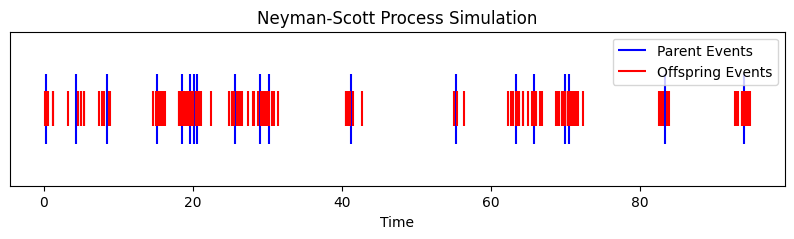

In [6]:
def simulate_neyman_scott_process_1d(h, theta, p, duration):
    """
    Simulate a 1D Neyman-Scott process as a function of time.

    Parameters:
    - h: Intensity of the Poisson process for parent events.
    - theta: Mean of the Poisson distribution for the number of offspring per parent event.
    - p: Standard deviation of the Gaussian distribution for the timing of offspring events relative to their parent.
    - duration: Duration of the process.

    Returns:
    - parent_times: A list of event times for parent events.
    - offspring_times: A list of event times for all offspring events.
    """
    # Simulate parent events
    expected_parents = h * duration
    parent_events = np.random.exponential(1/h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        # Number of offspring for each parent
        num_offspring = np.random.poisson(theta)
        # Offspring times relative to parent
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        # Filter offspring times to keep only those within the duration
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    return np.sort(parent_times), np.sort(offspring_times)

def plot_neyman_scott_process(h, theta, p, duration):
    parent_times, offspring_times = simulate_neyman_scott_process_1d(h, theta, p, duration)

    plt.figure(figsize=(10, 2))
    plt.eventplot(parent_times, lineoffsets=0, colors='blue', linelengths=0.4, label='Parent Events')
    plt.eventplot(offspring_times, lineoffsets=0, colors='red', linelengths=0.2, label='Offspring Events')
    plt.xlabel('Time')
    plt.yticks([])
    plt.title('Neyman-Scott Process Simulation')
    plt.legend()
    plt.show()

# Example usage:
plot_neyman_scott_process(h=0.23, theta=8, p=0.67, duration=100)


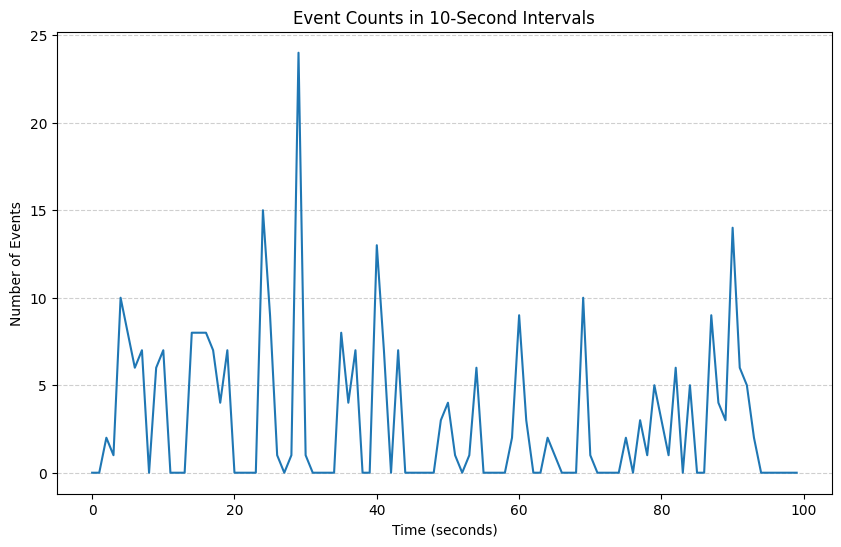

In [12]:
def simulate_and_count_neyman_scott_1d(h, theta, p, duration, N):
    """
    Simulate a 1D Neyman-Scott process over time and count events in N-second intervals.

    Parameters:
    - h: Intensity of the Poisson process for parent events (events per unit time).
    - theta: Mean of the Poisson distribution for the number of offspring per parent event.
    - p: Standard deviation of the Gaussian distribution for the timing of offspring events relative to their parent.
    - duration: Duration of the process.
    - N: Interval length, in seconds, for counting events.

    Returns:
    - interval_counts: A numpy array with the count of events in each N-second interval.
    """
    # Generate parent event times
    expected_parents = h * duration
    parent_events = np.random.exponential(1/h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        num_offspring = np.random.poisson(theta)
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    # Combine parent and offspring times and sort them
    all_event_times = np.sort(np.concatenate((parent_times, offspring_times)))

    # Count events in N-second intervals
    num_intervals = int(np.ceil(duration / N))
    interval_counts = np.zeros(num_intervals)

    for time in all_event_times:
        interval_index = int(time // N)
        if interval_index < num_intervals:
            interval_counts[interval_index] += 1

    return interval_counts

# Example usage
h = 0.05 # parent events intensity (events per unit time)
theta = 5  # mean number of offspring per parent
p = 3.  # standard deviation of offspring timing
duration = 1000  # total duration of the process in seconds
N = 10  # interval length in seconds for counting events

# Simulate the process and get event counts in N-second intervals
interval_counts = simulate_and_count_neyman_scott_1d(h, theta, p, duration, N)
interval_counts


plt.figure(figsize=(10, 6))
plt.plot(interval_counts)
plt.title(f'Event Counts in {N}-Second Intervals')
plt.xlabel('Time (seconds)')
plt.ylabel('Number of Events')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

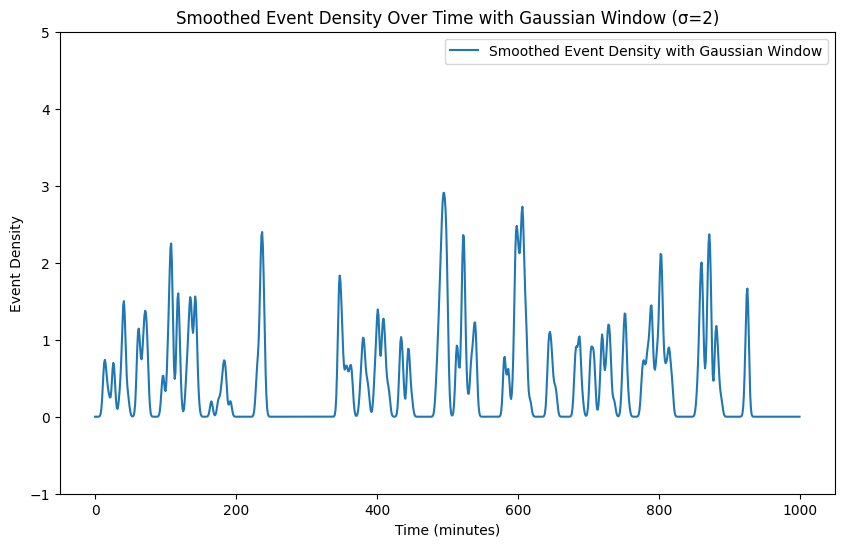

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d


def simulate_neyman_scott_process_1d(h, theta, p, duration):
    """
    Simulate a 1D Neyman-Scott process as a function of time.

    Parameters:
    - h: Intensity of the Poisson process for parent events.
    - theta: Mean of the Poisson distribution for the number of offspring per parent event.
    - p: Standard deviation of the Gaussian distribution for the timing of offspring events relative to their parent.
    - duration: Duration of the process.

    Returns:
    - parent_times: A list of event times for parent events.
    - offspring_times: A list of event times for all offspring events.
    """
    # Simulate parent events
    expected_parents = h * duration
    parent_events = np.random.exponential(1/h, int(np.ceil(expected_parents)))
    parent_times = np.cumsum(parent_events)
    parent_times = parent_times[parent_times < duration]

    offspring_times = []

    for parent_time in parent_times:
        # Number of offspring for each parent
        num_offspring = np.random.poisson(theta)
        # Offspring times relative to parent
        offspring_delays = np.random.randn(num_offspring) * p
        offspring_event_times = parent_time + offspring_delays
        # Filter offspring times to keep only those within the duration
        offspring_times.extend(offspring_event_times[(offspring_event_times >= 0) & (offspring_event_times <= duration)])

    return np.sort(parent_times), np.sort(offspring_times)


# Simulate the process
duration = 1000
_, event_times = simulate_neyman_scott_process_1d(h=0.05, theta=10., p=3., duration=duration)


def smooth_events_with_gaussian_window(event_times, duration, sigma, resolution=1):
    """
    Smooth event occurrences over time using a Gaussian window.

    Parameters:
    - event_times: A numpy array of event times.
    - duration: The total duration of the simulation, in seconds.
    - sigma: The standard deviation for the Gaussian kernel, controls the smoothing.
    - resolution: The time resolution of the simulation (default is 1 second).

    Returns:
    - A tuple containing the time series and the smoothed event density.
    """
    # Create a time series of event occurrences
    time_series_length = int(duration / resolution)
    event_series = np.zeros(time_series_length)

    # Mark the occurrences of events in the time series
    for time in event_times:
        if time < duration:
            index = int(time / resolution)
            event_series[index] += 1

    # Apply Gaussian window smoothing
    smoothed_series = gaussian_filter1d(event_series, sigma=sigma/resolution, mode='constant')

    # Generate time points for the x-axis
    times = np.arange(0, duration, resolution)

    return times, smoothed_series





# Parameters for smoothing with a Gaussian window
sigma = 2  # Standard deviation for the Gaussian kernel

# Simulate the process (assuming event_times and _ were previously generated)

# Smooth the event occurrences with a Gaussian window
times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=sigma)

# Plotting
plt.figure(figsize=(10, 6))
# plt.eventplot(event_times, label='Smoothed Event Density with Gaussian Window')
plt.plot(times, smoothed_series, label='Smoothed Event Density with Gaussian Window')
plt.title(f'Smoothed Event Density Over Time with Gaussian Window (σ={sigma})')
plt.xlabel('Time (minutes)')
plt.ylabel('Event Density')
plt.ylim(-1,5)
plt.legend()
plt.show()






tensor([0.0250, 0.0500, 0.0750, 0.1000, 0.1250, 0.1500, 0.1750, 0.2000, 0.2250,
        0.2500, 0.2750, 0.3000, 0.3250, 0.3500, 0.3750, 0.4000, 0.4250, 0.4500,
        0.4750, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])


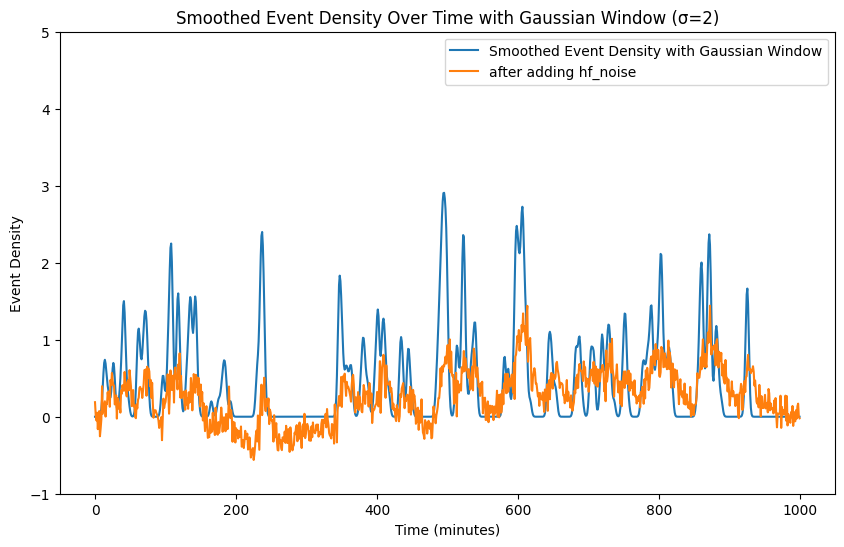

In [9]:
# simulation du process input:

# 1) On applique une conversion + une convolution
# 2) on applique un bruit lisse
# 3) On ajoute un bruit rouge de faible intensité
# 4) On ajoute une composante diurne



import torch
import torch.nn.functional as F

def apply_conv1d_with_custom_kernel(signal, kernel, stride=1):
    """
    Apply a 1D convolution to a signal with a custom kernel using PyTorch.

    Parameters:
    - signal: A 1D PyTorch tensor representing the input signal.
    - kernel: A 1D PyTorch tensor representing the custom convolutional kernel.
    - stride: The stride of the convolution. Defaults to 1.

    Returns:
    - The convolved signal as a 1D PyTorch tensor.
    """
    # Ensure the signal and kernel are properly formatted for conv1d
    signal = signal.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
    kernel = kernel.unsqueeze(0).unsqueeze(0)  # Add batch and out_channels dimensions

    # Calculate padding to maintain output size
    padding = (kernel.size(-1) - 1) // 2

    # Apply the 1D convolution
    convolved_signal = F.conv1d(signal, kernel, padding=padding, stride=stride)

    # Remove added dimensions to return to original signal shape
    convolved_signal = convolved_signal.squeeze(0).squeeze(0)

    return convolved_signal


def generate_random_sinusoidal_process(length, mean_poisson=10., phase_range=(0, 2 * np.pi)):
    """
    Generate a signal composed of a polynomial of sinusoids with random phases, coefficients, and periods.

    Parameters:
    - length: The number of points in the generated signal.
    - mean_poisson: The mean of the Poisson distribution for determining the number of components.
    - phase_range: The range (min, max) of possible phases for the sinusoids.
    - time_scale: Scale for the time axis (default 1.0).

    Returns:
    - A PyTorch tensor representing the generated signal.
    """
    # Determine the number of sinusoidal components
    num_components = 1 + torch.poisson(torch.tensor([mean_poisson])).int().item()

    # Sample coefficients from a normal distribution
    coefficients = torch.randn(num_components)

    # Sample periods from a uniform distribution between 120 and 24*60
    periods = torch.randint(low=240, high=24*60, size=(num_components,)).float()

    # Time axis
    t = torch.linspace(0, length, steps=length)

    # Initialize the signal
    signal = torch.zeros(length)

    # Generate each sinusoidal component
    for i in range(num_components):
        # Random phase for each component
        phase = torch.rand(1) * (phase_range[1] - phase_range[0]) + phase_range[0]

        # Sinusoidal component
        component = coefficients[i] * torch.sin(2 * np.pi * t / periods[i] + phase)

        # Add the component to the signal
        signal += component
    signal /= num_components
    signal /= 2
    return signal


def get_gaussian_noise(signal, noise_scale_func):
    """
    Apply Gaussian noise to a signal where the noise standard deviation varies non-linearly with the signal intensity.

    Parameters:
    - signal: A PyTorch tensor representing the input signal.
    - noise_scale_func: A function defining how the noise standard deviation scales with the signal intensity.

    Returns:
    - The signal with applied Gaussian noise.
    """
    # Compute the standard deviation of the noise for each point in the signal
    noise_std = noise_scale_func(signal)

    # Generate the Gaussian noise
    noise = torch.randn_like(signal) * noise_std

    return noise

# Define a non-linear noise scale function
def noise_scale_func(signal_intensity):
    # Example: Standard deviation of the noise scales with the square of the signal intensity
    return 0.1*torch.abs(1 + signal_intensity) ** 0.75



f = lambda x :  0.1*x**0.7
kernel = torch.tensor(np.concatenate([np.arange(0.025,0.5,0.025), np.array([1]), np.zeros(19)]), dtype=torch.float32)
print((kernel))


times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=sigma)
converted_smoothed_series = f(smoothed_series)
converted_smoothed_series = torch.tensor(converted_smoothed_series, dtype=torch.float32)
convolved_smoothed_series = apply_conv1d_with_custom_kernel(converted_smoothed_series, kernel, stride=1)

lf_noise = generate_random_sinusoidal_process(duration)
hf_noise = get_gaussian_noise(convolved_smoothed_series, noise_scale_func)

noisy1_series = convolved_smoothed_series + lf_noise
noisy2_series = noisy1_series + hf_noise

plt.figure(figsize=(10, 6))
# plt.eventplot(event_times, label='Smoothed Event Density with Gaussian Window')
plt.plot(times, smoothed_series, label='Smoothed Event Density with Gaussian Window')
# plt.plot(times, converted_smoothed_series, label='after conversion')
# plt.plot(times, convolved_smoothed_series, label='after convolution')
# plt.plot(times, noisy1_series, label='after adding lf_noise')
plt.plot(times, noisy2_series, label='after adding hf_noise')
plt.title(f'Smoothed Event Density Over Time with Gaussian Window (σ={sigma})')
plt.xlabel('Time (minutes)')
plt.ylabel('Event Density')
plt.ylim(-1,5)
plt.legend()
plt.show()

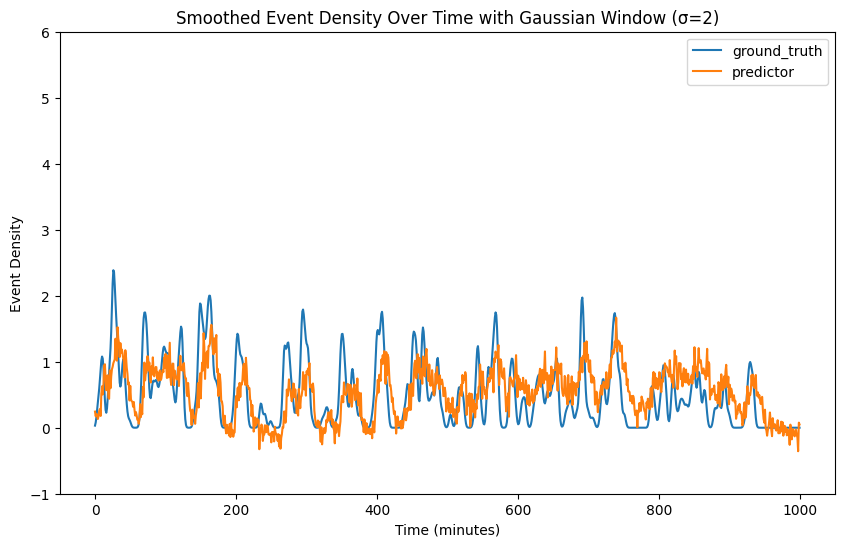

In [45]:
def modify_random_non_zero_interval(ground_truth, p):
    """
    Nullifies a random non-zero interval in the signal.

    Parameters:
    - signal: A 1D PyTorch tensor representing the signal.

    Returns:
    - A signal with one random non-zero interval set to zero.
    """
    signal = copy.deepcopy(ground_truth)
    # Identify non-zero intervals
    nonzero_indices = torch.where(signal != 0)[0]
    if len(nonzero_indices) == 0:
        return signal  # Return unchanged if no non-zero intervals

    # Detect changes between nonzero and zero
    changes = torch.diff(nonzero_indices) != 1
    interval_starts = torch.cat((nonzero_indices[:1], nonzero_indices[1:][changes]))
    interval_ends = torch.cat((nonzero_indices[:-1][changes], nonzero_indices[-1:]))

    # Choose a random interval to nullify
    num_intervals = len(interval_starts)
    random_interval_index = torch.randint(0, num_intervals, (1,)).item()
    random_interval_index2 = torch.randint(0, num_intervals, (1,)).item()
    while random_interval_index2 == random_interval_index:
        random_interval_index2 = torch.randint(0, num_intervals, (1,)).item()

    # Nullify the chosen interval
    start, end = interval_starts[random_interval_index], interval_ends[random_interval_index]
    signal[start:end+1] *= (1 + p)  # augmentation de p %
    start2, end2 = interval_starts[random_interval_index2], interval_ends[random_interval_index2]
    signal[start2:end2+1] *= (1 - p)  # diminution de p %
    return start, start2, signal


# def randomly_corrupt_reference(ground_truth, p):
#     """
#     Nullifies a random non-zero interval in the signal.

#     Parameters:
#     - signal: A 1D PyTorch tensor representing the signal.

#     Returns:
#     - A signal with one random non-zero interval set to zero.
#     """
#     signal = copy.deepcopy(ground_truth)

#     torch.randint(1,).item()


#     return start, start2, signal


def generate_pair(duration, p):
    _, event_times = simulate_neyman_scott_process_1d(h=0.05, theta=10., p=3., duration=duration)
    times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=2)
    converted_smoothed_series = f(smoothed_series)
    converted_smoothed_series = torch.tensor(converted_smoothed_series, dtype=torch.float32)
    convolved_smoothed_series = apply_conv1d_with_custom_kernel(converted_smoothed_series, kernel, stride=1)

    lf_noise = generate_random_sinusoidal_process(duration)
    hf_noise = get_gaussian_noise(convolved_smoothed_series, noise_scale_func)

    noisy1_series = convolved_smoothed_series + lf_noise

    ground_truth = torch.tensor(smoothed_series, dtype=torch.float32)
    start, start2, reference = modify_random_non_zero_interval(ground_truth, p)
    noisy_series = noisy1_series + hf_noise

    return ground_truth, start, start2, reference, noisy_series


def generate_pair2(duration, distance):
    # ppp_intensity is inversely proportional to the distance
    ppp_intensity = 0.05 * distance
    _, event_times = simulate_neyman_scott_process_1d(h=ppp_intensity, theta=10., p=3., duration=duration)
    times, smoothed_series = smooth_events_with_gaussian_window(event_times, duration=duration, sigma=2)
    converted_smoothed_series = f(smoothed_series)
    converted_smoothed_series = torch.tensor(converted_smoothed_series, dtype=torch.float32)
    convolved_smoothed_series = apply_conv1d_with_custom_kernel(converted_smoothed_series, kernel, stride=1)

    lf_noise = generate_random_sinusoidal_process(duration)
    hf_noise = get_gaussian_noise(convolved_smoothed_series, noise_scale_func)

    noisy1_series = convolved_smoothed_series + lf_noise

    ground_truth_specific = torch.tensor(smoothed_series, dtype=torch.float32)
    ground_truth = ground_truth_specific * 1/distance
    noisy_series = noisy1_series + hf_noise

    return ground_truth, noisy_series



ground_truth, noisy_series = generate_pair2(1000,  2.)

plt.figure(figsize=(10, 6))
# plt.eventplot(event_times, label='Smoothed Event Density with Gaussian Window')
plt.plot(times, ground_truth, label='ground_truth')
plt.plot(times, noisy_series, label='predictor')
plt.title(f'Smoothed Event Density Over Time with Gaussian Window (σ={sigma})')
plt.xlabel('Time (minutes)')
plt.ylabel('Event Density')
plt.ylim(-1,6)
plt.legend()
plt.show()

In [46]:
# Dictionary with "distances" for 2,000 pseudo CML ids.

idx2distance = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 2000)}

In [51]:
import torch
from torch.utils.data import Dataset, DataLoader


# Step 1: Define the Dataset Class
class TensorPairDataset(Dataset):
    def __init__(self, duration, cmlid2distance):
        self.duration = duration
        self.idx2distance = idx2distance
        self.num_cmls = len(idx2distance)

    def __len__(self):
        return self.num_cmls

    def __getitem__(self, idx):
        ground_truth, noisy_series = generate_pair2(self.duration, self.idx2distance[idx])

        # normalisation:
        noisy_series = 0.3 * noisy_series
        return ground_truth, noisy_series

# Step 2: Create the DataLoader
def create_dataloader(duration, idx2distance, batch_size, shuffle=True):
    dataset = TensorPairDataset(duration, idx2distance)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return dataloader


duration = 1024  # Duration for each tensor pair
batch_size = 64  # Number of samples per batch
dataloader = create_dataloader(duration, idx2distance, batch_size)

In [52]:
%%timeit -n 1 -r 1
for batch_idx, (ground_truth, noisy_series) in enumerate(dataloader):
  if batch_idx == 20:
    break

print(20 * 64)

1280
4.21 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
! git clone

In [ ]:
# Learning CDE:
##############################################################################################
################################   UNet (parties)#############################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x




class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

#Given transposed=1, weight[1024, 256, 2, 2], so expected input[64, 512, 4, 4] to have 1024 channels, but got 512 channels instead



class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')#nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        # diffY = x1.size()[3] - x2.size()[3]
        # x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
        #                 diffY // 2, int(diffY / 2)))
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


###############################################################################################################################################
######################################## Montage Unet ################################################################################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x





In [ ]:
# Learning CDE:
##############################################################################################
################################   UNet (parties)#############################################
import torch
import torch.nn as nn
import torch.nn.functional as F

class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x




class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool1d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

#Given transposed=1, weight[1024, 256, 2, 2], so expected input[64, 512, 4, 4] to have 1024 channels, but got 512 channels instead



class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear')#nn.UpsamplingBilinear2d(scale_factor=2)
        else:
            self.up = nn.ConvTranspose1d(in_ch, in_ch, kernel_size=2, stride=2)

        self.conv = double_conv(2*in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffX = x1.size()[2] - x2.size()[2]
        # diffY = x1.size()[3] - x2.size()[3]
        # x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
        #                 diffY // 2, int(diffY / 2)))
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2)))

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv1d(in_ch, out_ch, 1)


    def forward(self, x):
        x = self.conv(x)
        return x


###############################################################################################################################################
######################################## Montage Unet ################################################################################

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes,size=64):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, size)
        self.down1 = Down(size, 2*size)
        self.down2 = Down(2*size, 4*size)
        self.down3 = Down(4*size, 8*size)
        self.down4 = Down(8*size, 8*size)
        self.up1 = Up(8*size, 4*size)
        self.up2 = Up(4*size, 2*size)
        self.up3 = Up(2*size, size)
        self.up4 = Up(size, size)
        self.outc = outconv(size, n_classes)
        self.n_classes=n_classes

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        del x4, x5
        x = self.up2(x, x3)
        del x3
        x = self.up3(x, x2)
        del x2
        x = self.up4(x, x1)
        del x1
        x = self.outc(x)
        return   x





In [ ]:
import torch.optim as optim

model = UNet(1, 1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

num_epochs = 50  # Adjust based on your needs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

        inputs, targets = noisy_series.to(device), \
                          reference.to(device)

        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/50], Loss: 0.2498
Epoch [2/50], Loss: 0.1067
Epoch [3/50], Loss: 0.0893
Epoch [4/50], Loss: 0.0835
Epoch [5/50], Loss: 0.0809
Epoch [6/50], Loss: 0.0800
Epoch [7/50], Loss: 0.0795
Epoch [8/50], Loss: 0.0783
Epoch [9/50], Loss: 0.0768
Epoch [10/50], Loss: 0.0780
Epoch [11/50], Loss: 0.0764
Epoch [12/50], Loss: 0.0749
Epoch [13/50], Loss: 0.0752
Epoch [14/50], Loss: 0.0749
Epoch [15/50], Loss: 0.0753
Epoch [16/50], Loss: 0.0750
Epoch [17/50], Loss: 0.0769
Epoch [18/50], Loss: 0.0764
Epoch [19/50], Loss: 0.0757
Epoch [20/50], Loss: 0.0764
Epoch [21/50], Loss: 0.0748
Epoch [22/50], Loss: 0.0768
Epoch [23/50], Loss: 0.0754
Epoch [24/50], Loss: 0.0750
Epoch [25/50], Loss: 0.0763
Epoch [26/50], Loss: 0.0748
Epoch [27/50], Loss: 0.0739
Epoch [28/50], Loss: 0.0750
Epoch [29/50], Loss: 0.0752
Epoch [30/50], Loss: 0.0724
Epoch [31/50], Loss: 0.0728
Epoch [32/50], Loss: 0.0751
Epoch [33/50], Loss: 0.0754
Epoch [34/50], Loss: 0.0737
Epoch [35/50], Loss: 0.0747
Epoch [36/50], Loss: 0.0746
E

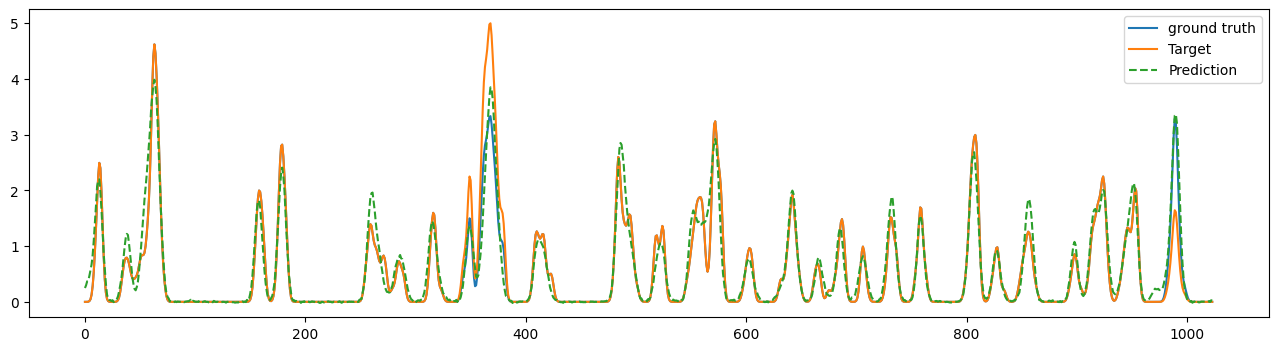

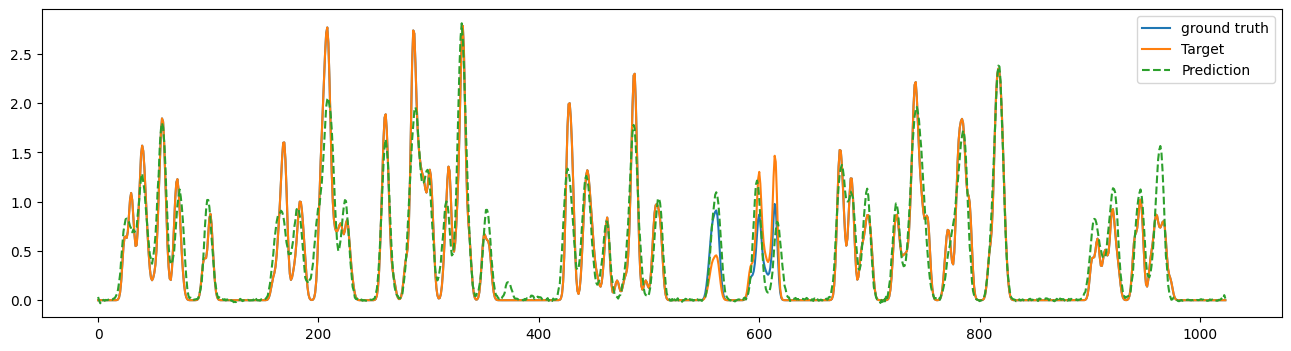

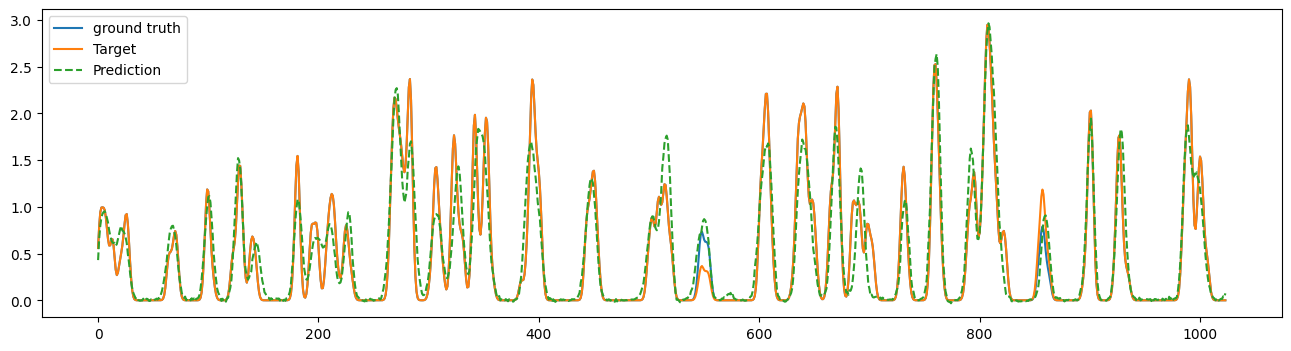

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, data_loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()

            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(ground_truth[i].squeeze(), label='ground truth')
                plt.plot(reference[i].squeeze(), label='Target')
                plt.plot(outputs[i].squeeze(), label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch

visualize_predictions(model, dataloader, num_samples=3)


In [ ]:
# Multiple quantile regression:

def dot1d(t, M):
	return (M * t.view((1,t.shape[0],1)) ).sum(dim=1)

class QuantileLoss1d(torch.nn.Module):

    def __init__(self , n):
        super(QuantileLoss1d, self).__init__()
        self.n = n   # n= 100 -> centiles
        self.t = torch.arange(1/n,1,1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx = target.shape
        d = target.view(bs, 1, nx) - output
        loss_by_pix = dot1d(self.t , d.clamp(min =0)) \
                      + dot1d(self.t - 1 , d.clamp(max =0))
        loss = torch.mean(loss_by_pix)

        return loss







In [ ]:
n = 100
model = UNet(1, n-1, 16).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = QuantileLoss1d(n)

In [ ]:
num_epochs = 50  # Adjust based on your needs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

        inputs, targets = noisy_series.to(device), \
                          reference.to(device)

        inputs = inputs.unsqueeze(1)
        targets = targets.unsqueeze(1)

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}')

Epoch [1/50], Loss: 5.1871
Epoch [2/50], Loss: 5.1695
Epoch [3/50], Loss: 5.1733
Epoch [4/50], Loss: 5.1629
Epoch [5/50], Loss: 5.1766
Epoch [6/50], Loss: 5.1355
Epoch [7/50], Loss: 5.1695
Epoch [8/50], Loss: 5.1618
Epoch [9/50], Loss: 5.2095
Epoch [10/50], Loss: 5.2022
Epoch [11/50], Loss: 5.1771
Epoch [12/50], Loss: 5.2009
Epoch [13/50], Loss: 5.1404
Epoch [14/50], Loss: 5.1523
Epoch [15/50], Loss: 5.2025
Epoch [16/50], Loss: 5.2079
Epoch [17/50], Loss: 5.2124
Epoch [18/50], Loss: 5.1226
Epoch [19/50], Loss: 5.1628
Epoch [20/50], Loss: 5.1756
Epoch [21/50], Loss: 5.1507
Epoch [22/50], Loss: 5.1938
Epoch [23/50], Loss: 5.2005
Epoch [24/50], Loss: 5.2202
Epoch [25/50], Loss: 5.1835
Epoch [26/50], Loss: 5.1237
Epoch [27/50], Loss: 5.1544
Epoch [28/50], Loss: 5.1449
Epoch [29/50], Loss: 5.1545
Epoch [30/50], Loss: 5.1149
Epoch [31/50], Loss: 5.1541
Epoch [32/50], Loss: 5.1825
Epoch [33/50], Loss: 5.1798
Epoch [34/50], Loss: 5.1440
Epoch [35/50], Loss: 5.1579
Epoch [36/50], Loss: 5.1382
E

torch.Size([64, 99, 1024])


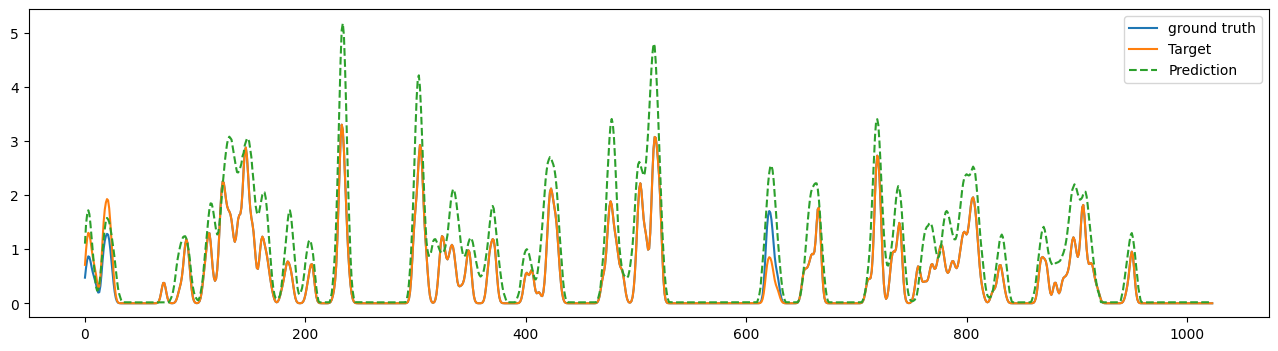

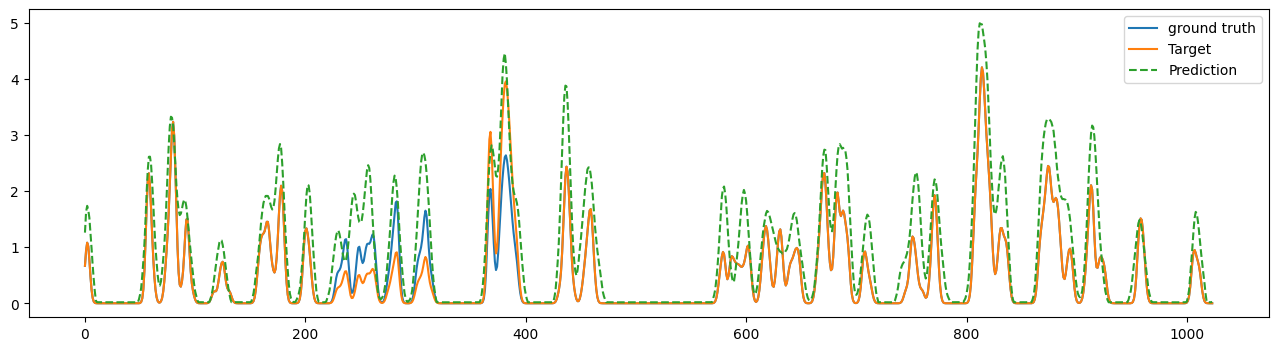

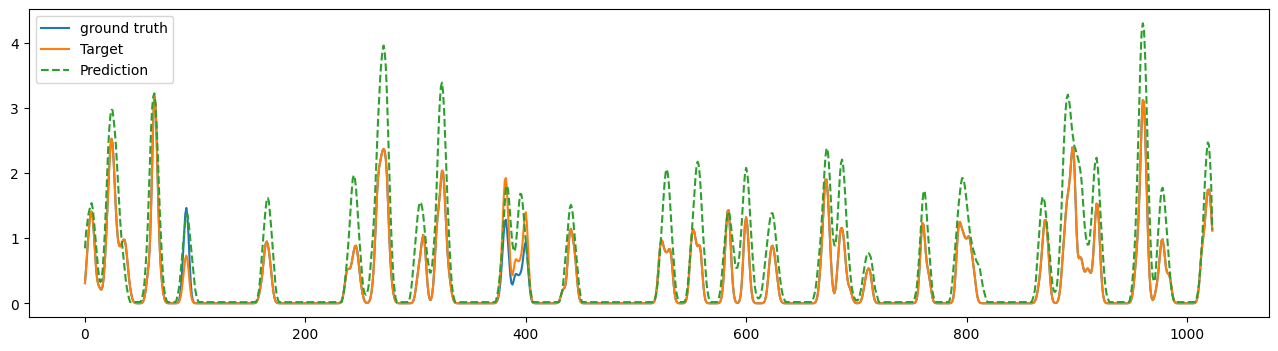

In [ ]:
def visualize_95th_quantile(model, data_loader, num_samples=1):
    model.eval()
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()
            print(outputs.shape)
            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(ground_truth[i].squeeze(), label='ground truth')
                plt.plot(reference[i].squeeze(), label='Target')
                plt.plot(outputs[i,95], label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch



visualize_95th_quantile(model, dataloader, num_samples=3)

torch.Size([64, 99, 1024])


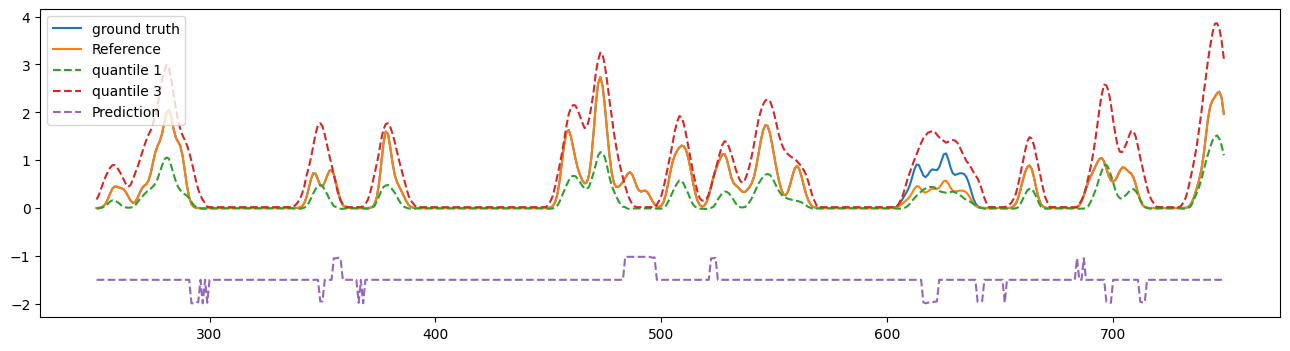

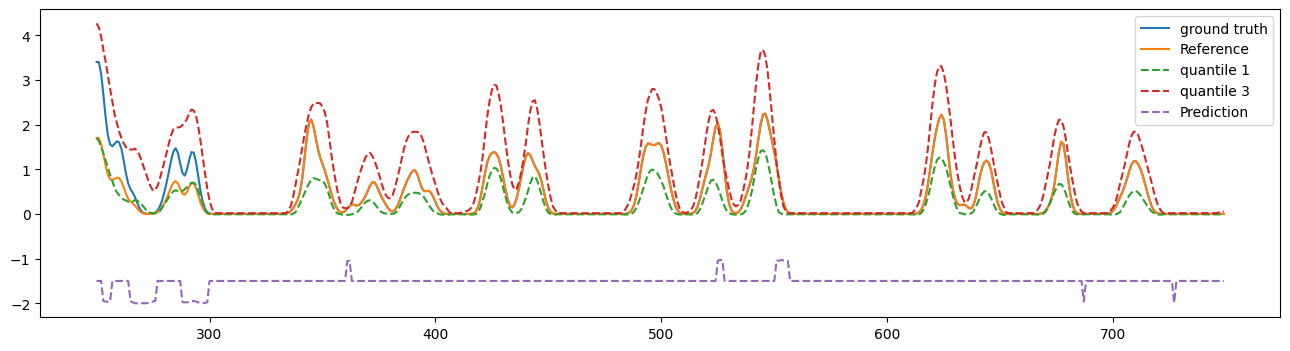

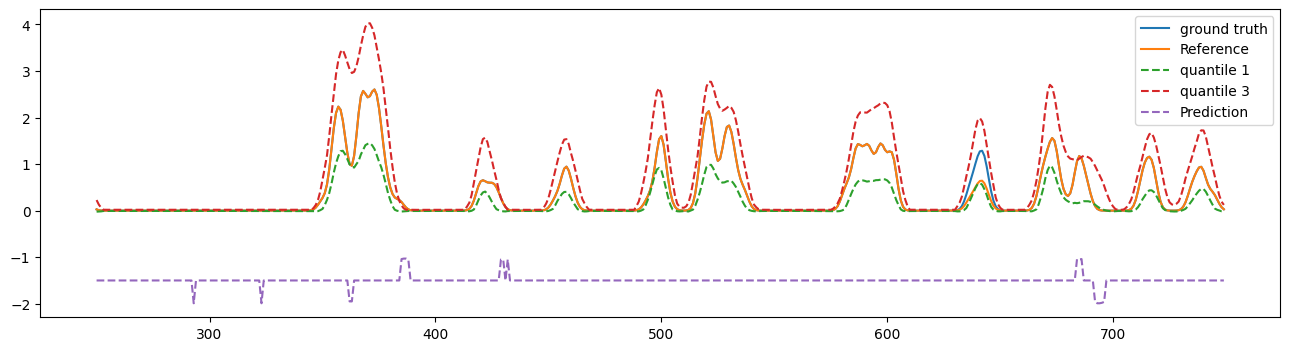

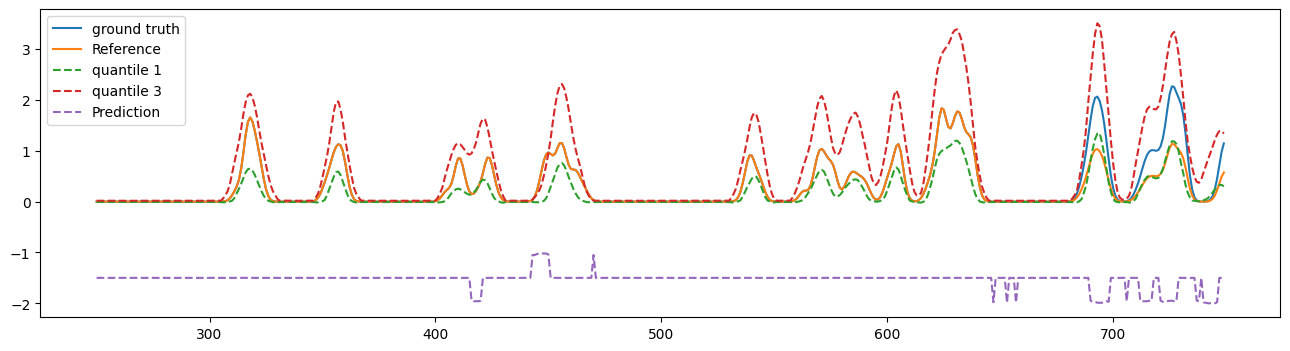

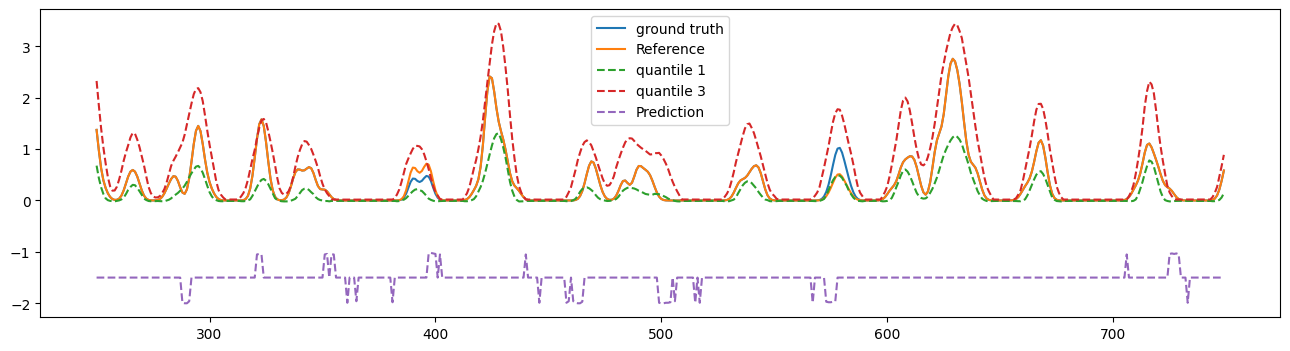

In [ ]:


def find_nearest_quantile_indices(quantiles, target):
    """
    For each component of the target tensor, find the index of the nearest quantile.

    Parameters:
    - quantiles: A tensor of shape [num_quantiles, length], containing the quantile values.
    - target: A tensor of shape [length], containing the target values.

    Returns:
    - A tensor of shape [length], where each component is the index of the nearest quantile to the corresponding target value.
    """
    # Calculate the absolute difference between each quantile and the target
    diff = torch.abs(quantiles - target.unsqueeze(0))  # Unsqueeze target to broadcast over quantiles

    # Identify the index of the median quantile
    median_quantile_index = quantiles.shape[0] // 2

    # Initialize a tensor to store the index of the nearest quantile for each time step
    nearest_quantile_indices = torch.empty(target.shape, dtype=torch.long)

    # For each time step, find the index of the nearest quantile
    for i in range(target.shape[0]):
        column_diff = diff[:, i]
        min_diff = torch.min(column_diff)
        # Find indices with the minimum difference
        min_indices = torch.where(column_diff == min_diff)[0]

        if len(min_indices) > 1:
            # If there's a tie, choose the index closest to the median quantile index
            nearest_quantile_index = min_indices[torch.argmin(torch.abs(min_indices - median_quantile_index))]
        else:
            nearest_quantile_index = min_indices[0]

        nearest_quantile_indices[i] = min_indices[0] #nearest_quantile_index

    return nearest_quantile_indices






def visualize_target_quantile(model, data_loader, num_samples=1):
    model.eval()
    k1 = 250
    k2 = 750
    qo = 0.05
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()
            print(outputs.shape)
            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(range(k1,k2), ground_truth[i].squeeze()[k1:k2], label='ground truth')
                plt.plot(range(k1,k2),reference[i].squeeze()[k1:k2], label='Reference')
                plt.plot(range(k1,k2),outputs[i,int(100*qo)][k1:k2], label='quantile 1', linestyle='--')
                plt.plot(range(k1,k2), outputs[i,int(100*(1-qo))][k1:k2], label='quantile 3', linestyle='--')
                nearest_quantile = find_nearest_quantile_indices(outputs[i], reference[i].squeeze()) / 100.
                nearest_quantile[(nearest_quantile < 1-qo) * (nearest_quantile > qo)] = 0.5
                plt.plot(range(k1,k2), nearest_quantile[k1:k2] -2, label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch




visualize_target_quantile(model, dataloader, num_samples=5)

[(672, 0.2404727339744568), (365, 0.18375009298324585), (1008, 0.09812498092651367), (626, 0.0923076868057251), (453, 0.09191489219665527)] 365 672


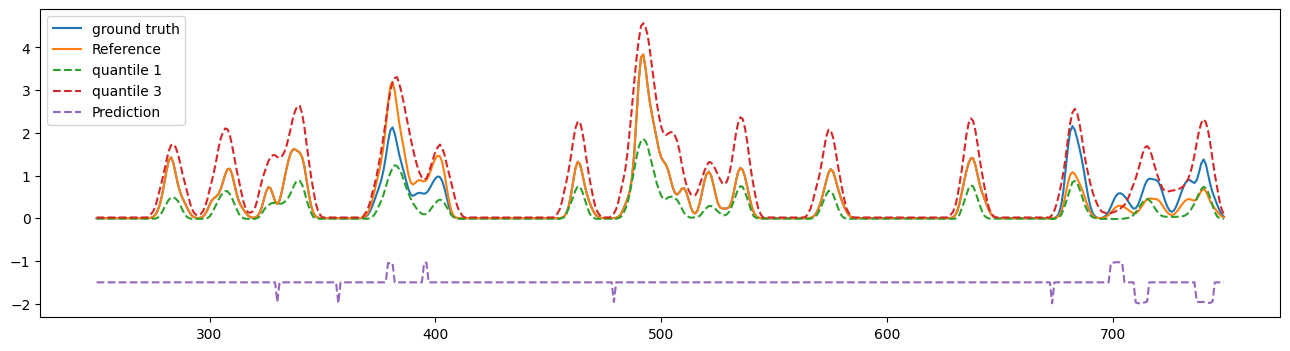

[(343, 0.2456880509853363), (6, 0.1922580599784851), (717, 0.1697435975074768), (122, 0.16750001907348633), (758, 0.12607145309448242)] 6 343


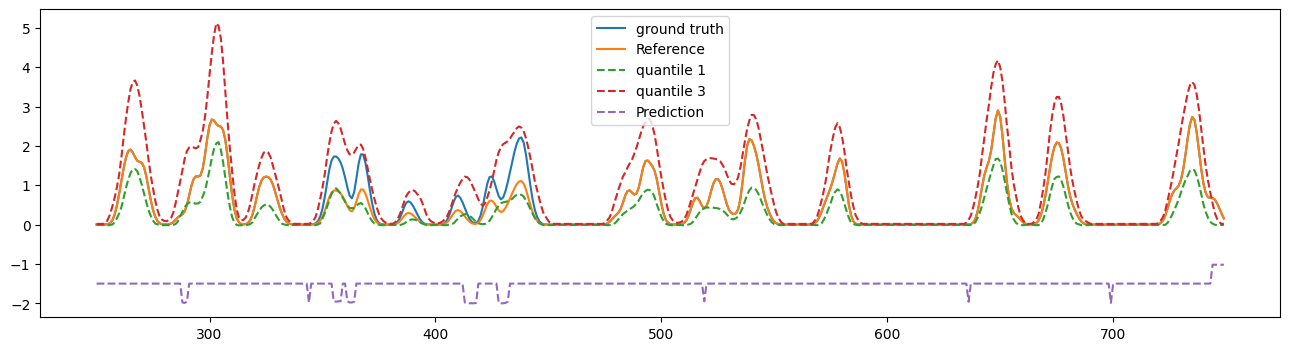

[(130, 0.20956522226333618), (661, 0.20919999480247498), (161, 0.20779573917388916), (0, 0.16798317432403564), (609, 0.06533333659172058)] 130 661


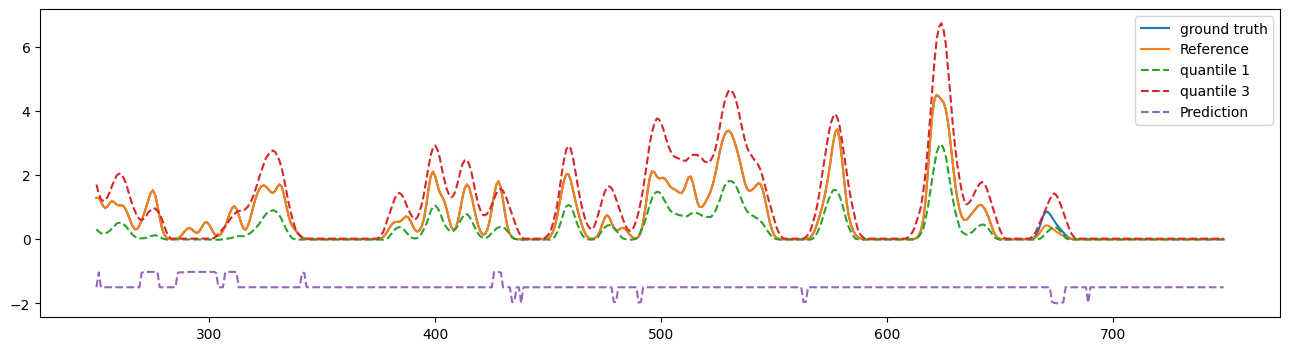

[(996, 0.28208333253860474), (25, 0.25896552205085754), (442, 0.22846156358718872), (219, 0.1489654779434204), (679, 0.14696967601776123)] 442 25


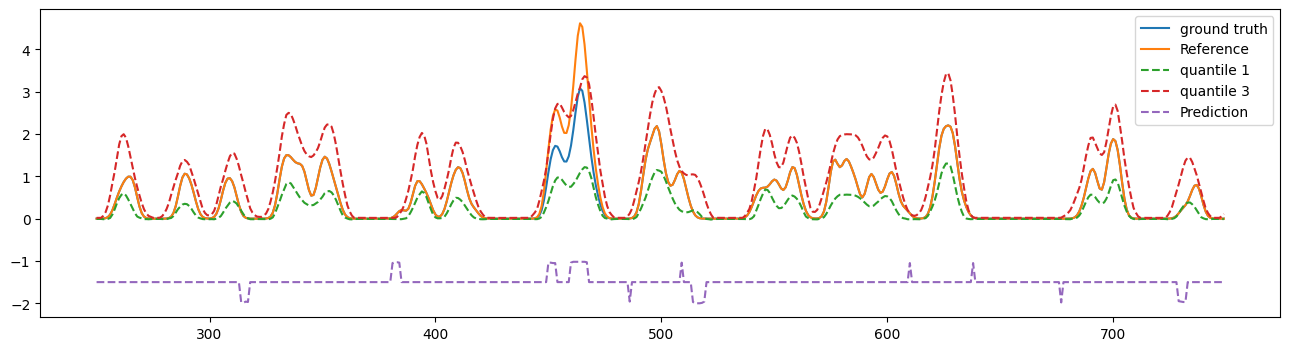

[(124, 0.37666667252779007), (159, 0.2288888692855835), (284, 0.18693548440933228), (210, 0.17680001258850098), (72, 0.12148141860961914)] 284 124


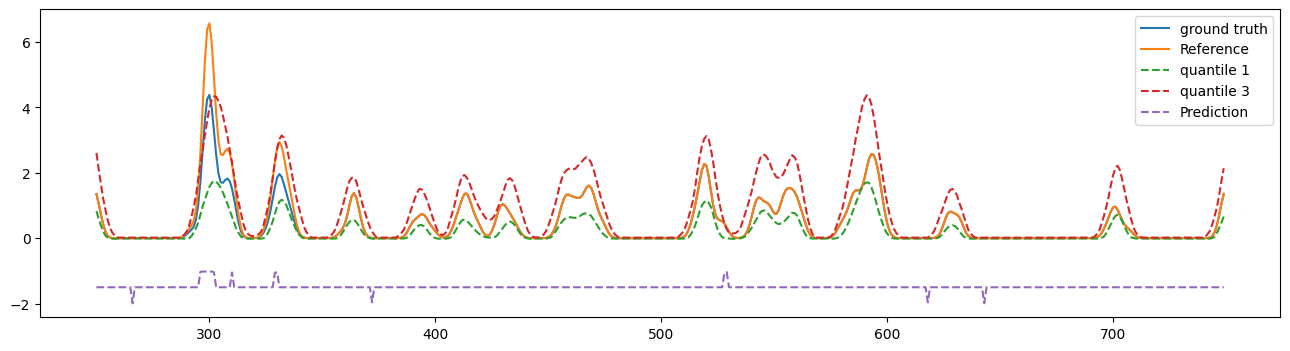

[(234, 0.3315872997045517), (459, 0.2959677577018738), (800, 0.157647043466568), (950, 0.15088236331939697), (629, 0.1335848569869995)] 459 234


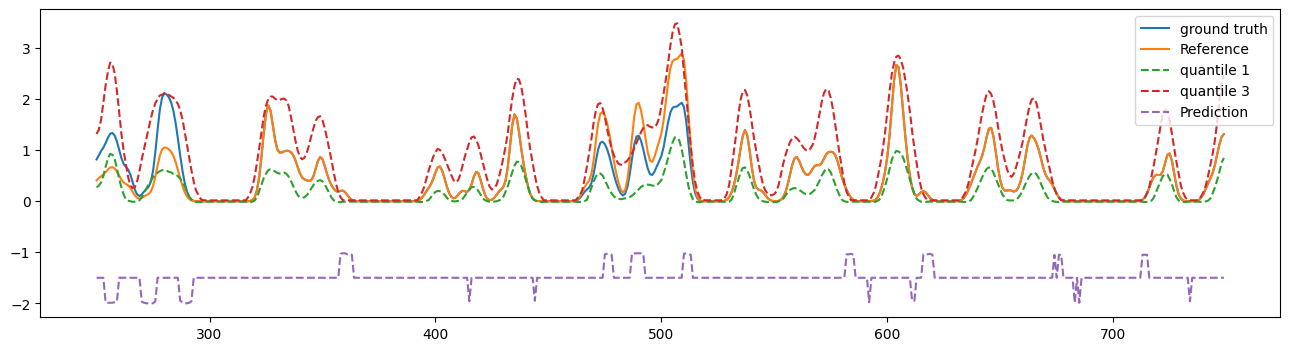

[(104, 0.3542499840259552), (164, 0.21890908479690552), (381, 0.18621623516082764), (423, 0.1349397599697113), (696, 0.09376806020736694)] 164 104


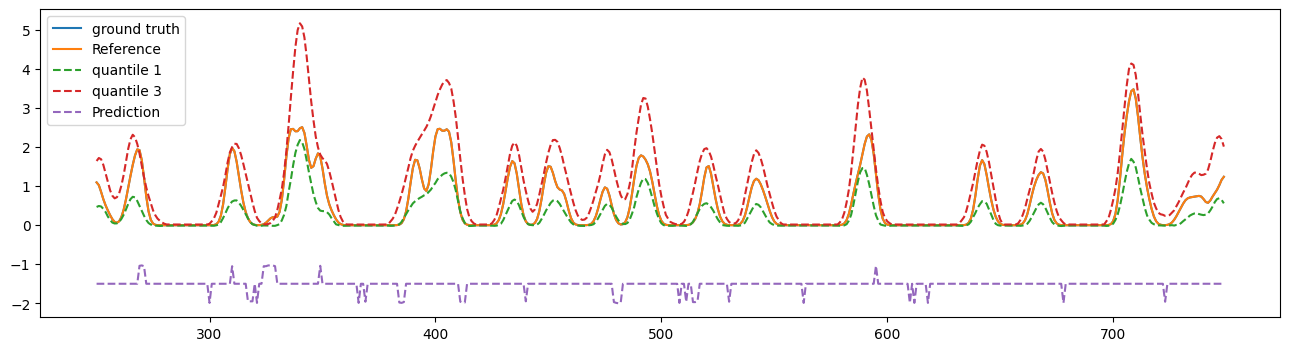

[(933, 0.36119048297405243), (0, 0.3085293769836426), (261, 0.11239129304885864), (651, 0.10805553197860718), (710, 0.09775000810623169)] 0 933


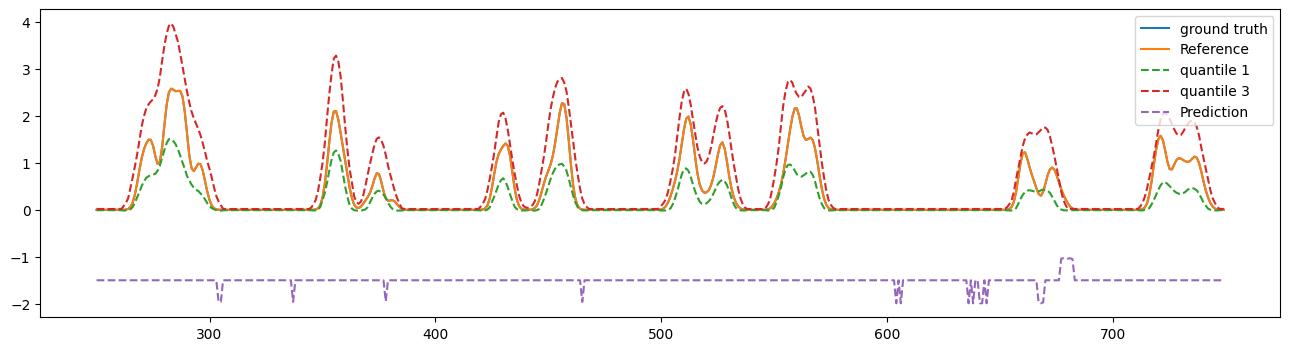

[(542, 0.17813563346862793), (224, 0.1771739423274994), (794, 0.13038456439971924), (835, 0.10950005054473877), (0, 0.09977948665618896)] 404 224


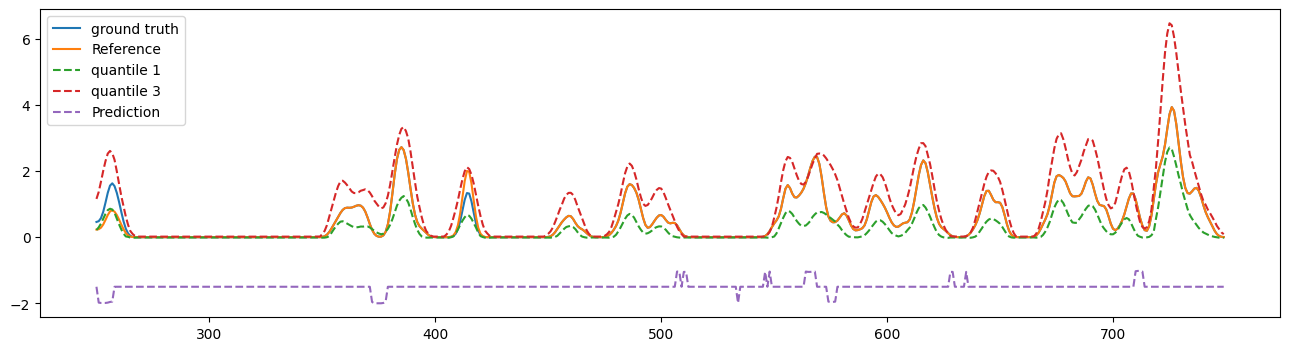

[(924, 0.3002777695655823), (269, 0.26789748668670654), (485, 0.20730769634246826), (202, 0.1482352912425995), (145, 0.1431250274181366)] 269 202


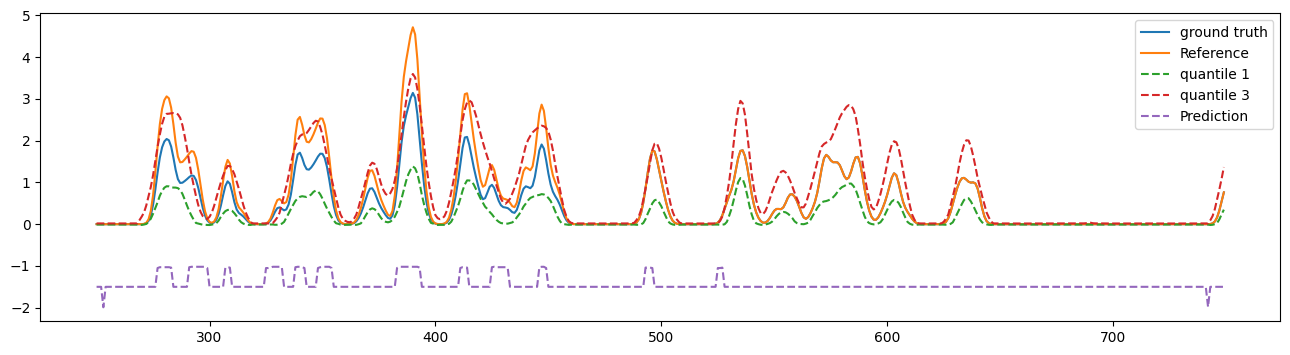

[(490, 0.3739999830722809), (302, 0.24074071645736694), (187, 0.13718748092651367), (759, 0.12833333015441895), (556, 0.11513513326644897)] 302 490


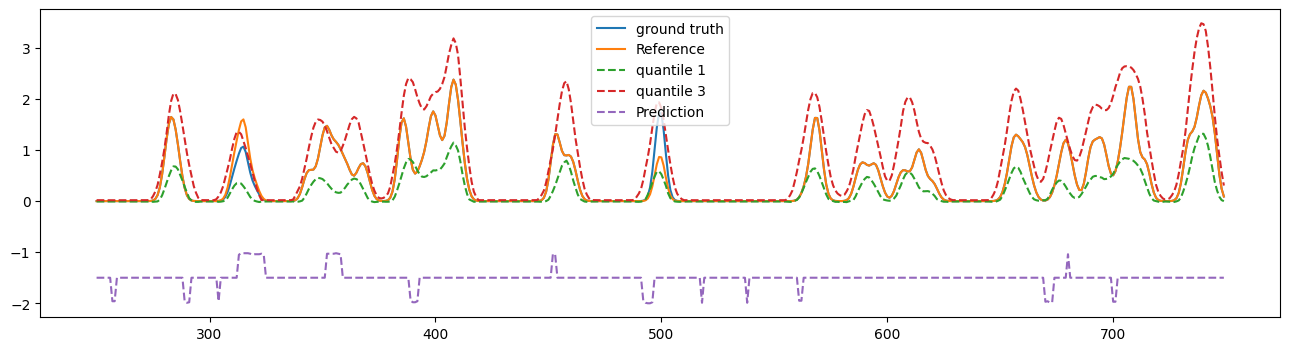

[(0, 0.2824999690055847), (206, 0.1876000165939331), (65, 0.17166656255722046), (17, 0.16161292791366577), (622, 0.11800003051757812)] 206 964


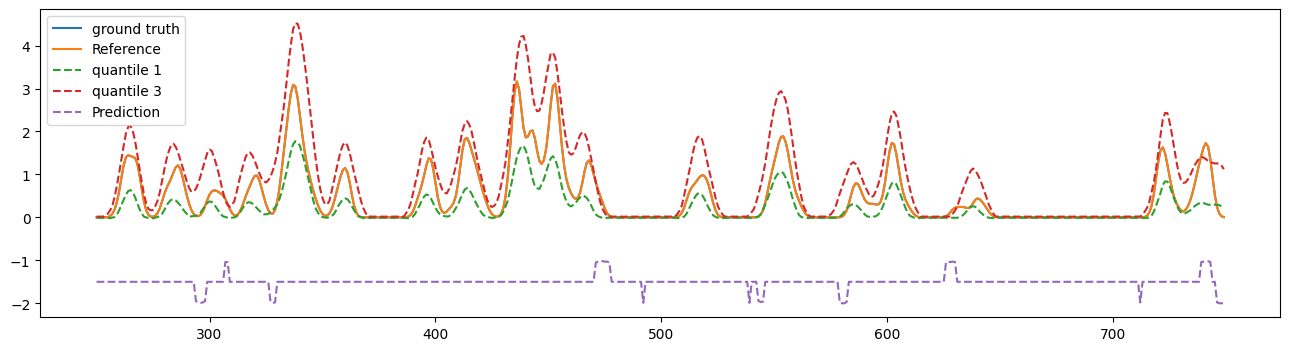

[(149, 0.33835165202617645), (391, 0.26333338022232056), (813, 0.16360002756118774), (731, 0.15451616048812866), (873, 0.11196082830429077)] 391 149


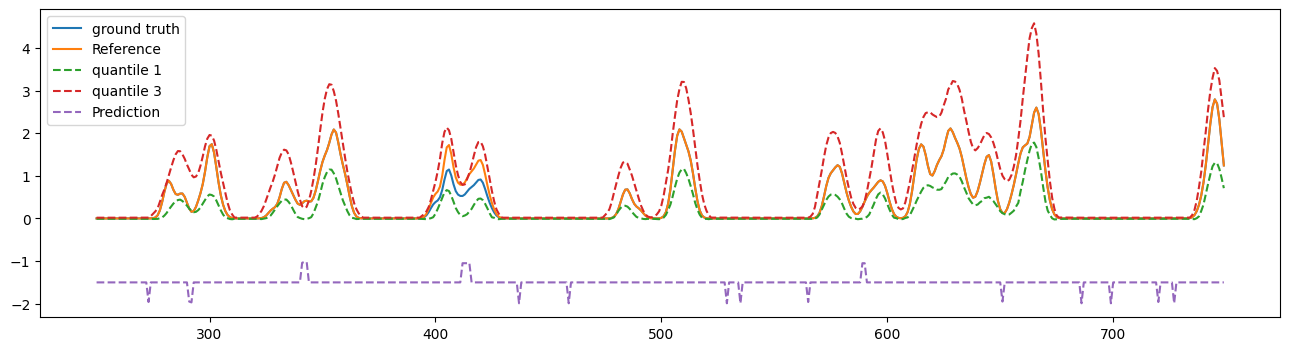

[(669, 0.33254237473011017), (845, 0.2772413492202759), (482, 0.2401714324951172), (731, 0.23760002851486206), (190, 0.23571428656578064)] 845 669


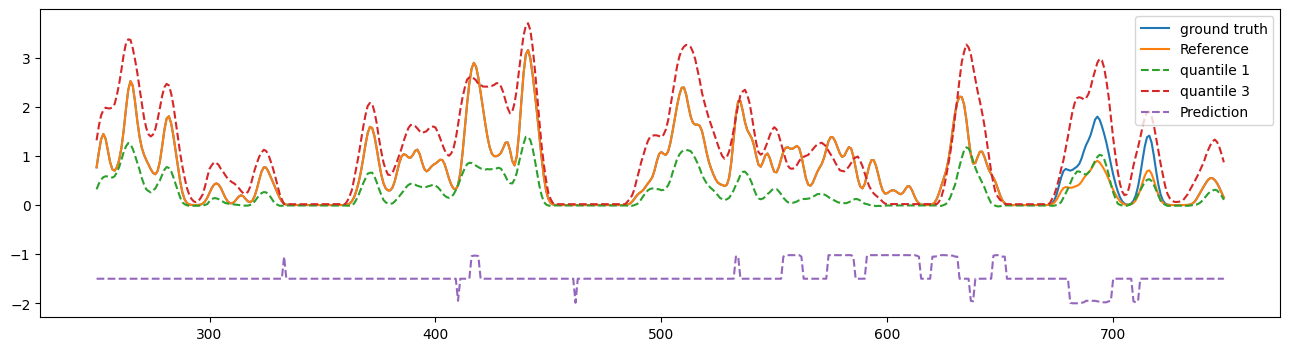

[(280, 0.2496969997882843), (1000, 0.16583329439163208), (321, 0.15541663765907288), (768, 0.1363999843597412), (495, 0.1213333010673523)] 1000 280


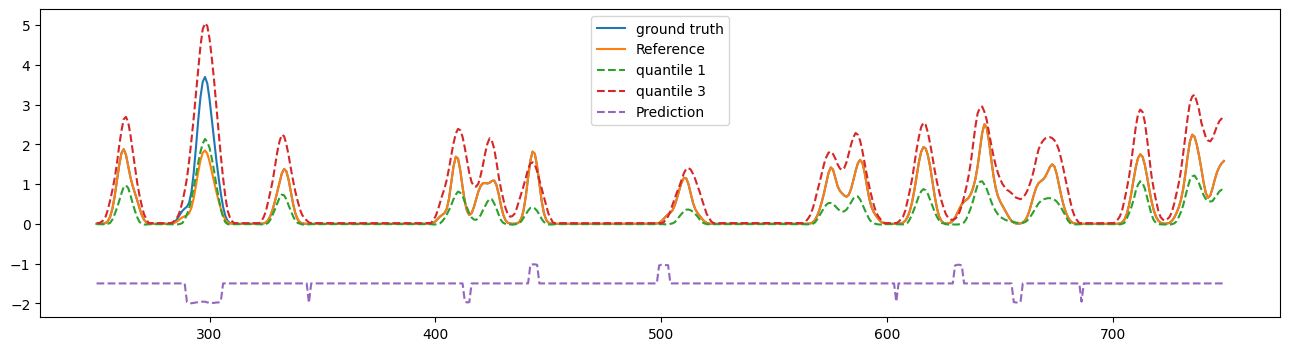

[(124, 0.2953488528728485), (16, 0.24619048833847046), (1006, 0.2177777886390686), (81, 0.21567565202713013), (567, 0.19821423292160034)] 1006 124


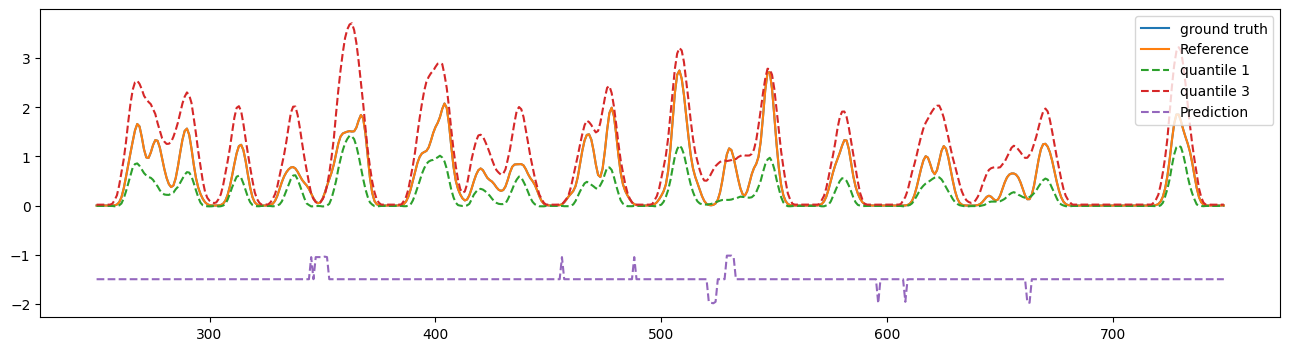

[(263, 0.4061038941144943), (786, 0.3199999928474426), (345, 0.29499998688697815), (22, 0.21410256624221802), (506, 0.19708329439163208)] 678 263


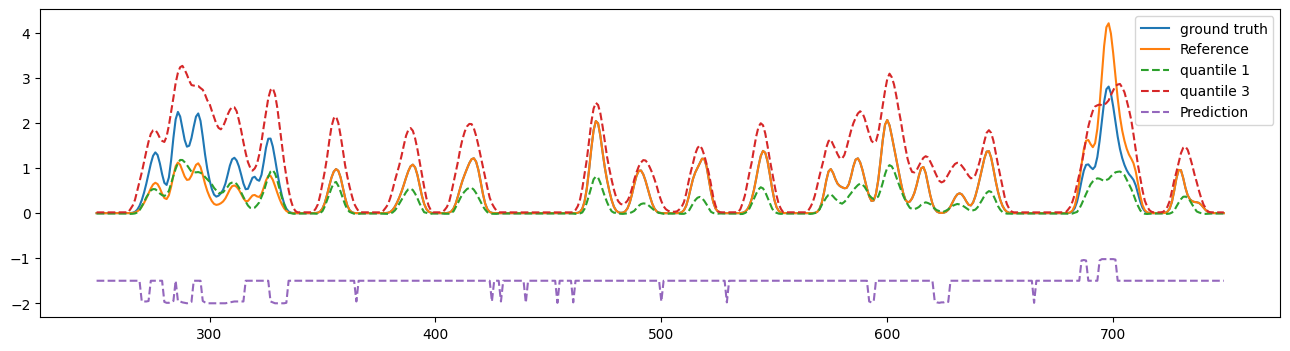

[(761, 0.29685717821121216), (388, 0.20880600810050964), (54, 0.18043166399002075), (693, 0.1799999475479126), (961, 0.07380950450897217)] 761 388


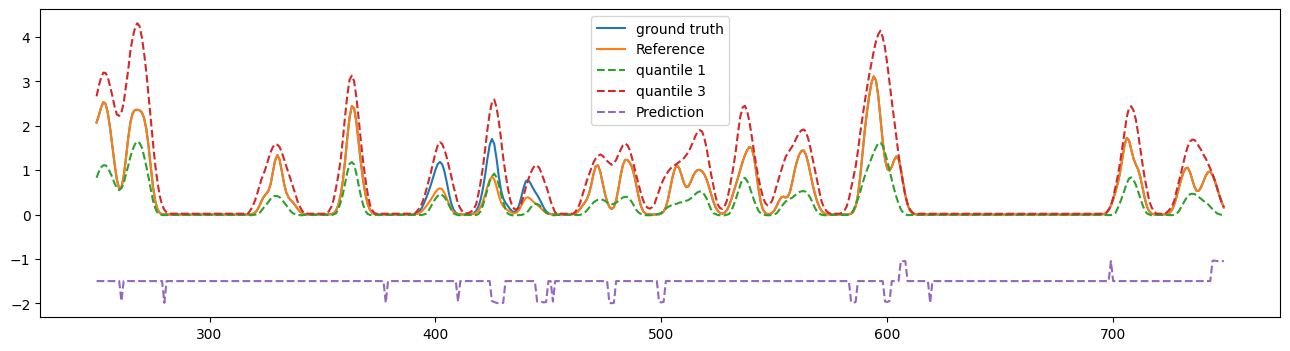

[(530, 0.41716667264699936), (662, 0.21079999208450317), (138, 0.20461538434028625), (418, 0.10874998569488525), (8, 0.10762497782707214)] 100 530


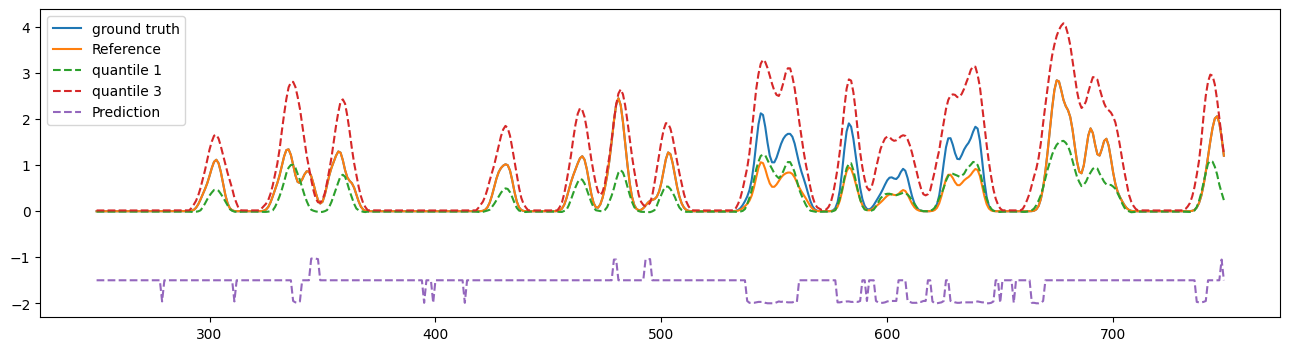

[(681, 0.33327585458755493), (1009, 0.3073333203792572), (799, 0.2477359175682068), (566, 0.2434374988079071), (0, 0.17075002193450928)] 799 681


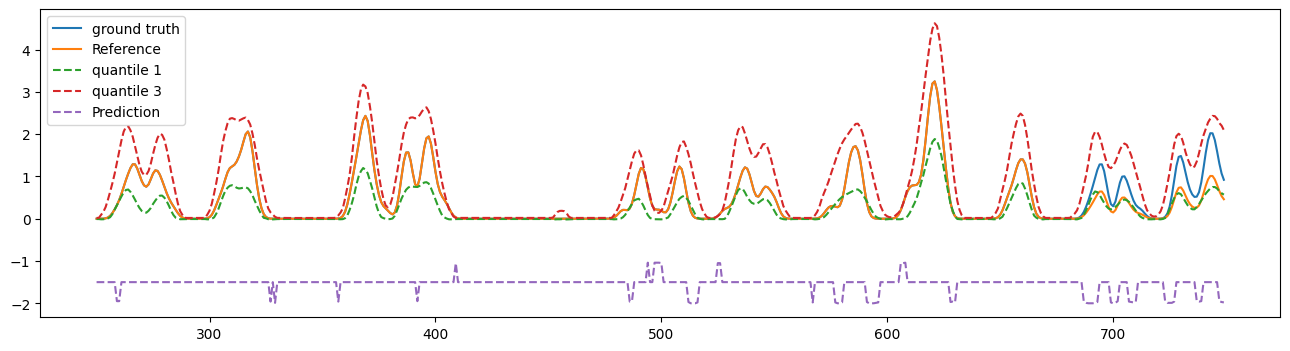

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
0.9


In [ ]:
import torch

def mean_quantile_per_non_zero_interval(ground_truth, quantile_order):
    """
    For each non-zero interval in the ground truth, compute the mean quantile order.

    Parameters:
    - ground_truth: A 1D PyTorch tensor representing the ground truth signal.
    - quantile_order: A 1D PyTorch tensor representing the order of the predicted quantile for each time step.

    Returns:
    - A list of tuples, each containing the start of the interval and the mean quantile order, sorted by the mean quantile order.
    """
    # Identify non-zero intervals
    nonzero_positions = ground_truth.nonzero(as_tuple=True)[0]
    if len(nonzero_positions) == 0:
        return []  # Return empty list if there are no non-zero intervals

    diffs = torch.diff(nonzero_positions)
    boundaries = torch.where(diffs > 1)[0]
    interval_starts = torch.cat((nonzero_positions[:1], nonzero_positions[boundaries + 1]))
    interval_ends = torch.cat((nonzero_positions[boundaries], nonzero_positions[-1:]))

    # Compute mean quantile order for each interval
    intervals_info = []
    for start, end in zip(interval_starts, interval_ends):
        interval_quantile_orders = quantile_order[start:end + 1]
        mean_quantile_order = torch.mean(interval_quantile_orders).item()
        intervals_info.append((start.item(), np.abs(mean_quantile_order-0.5)))

    # Sort the list by the mean quantile order
    sorted_intervals_info = sorted(intervals_info, key=lambda x: x[1], reverse=True)

    return sorted_intervals_info

def visualize_aggregated_target_quantile(model, data_loader, num_samples=1):
    model.eval()
    k1 = 250
    k2 = 750
    qo = 0.05
    anomaly_prediction = []
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()
            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(range(k1,k2), ground_truth[i].squeeze()[k1:k2], label='ground truth')
                plt.plot(range(k1,k2), reference[i].squeeze()[k1:k2], label='Reference')
                plt.plot(range(k1,k2), outputs[i,int(100*qo)][k1:k2], label='quantile 1', linestyle='--')
                plt.plot(range(k1,k2), outputs[i,int(100*(1-qo))][k1:k2], label='quantile 3', linestyle='--')
                nearest_quantile = find_nearest_quantile_indices(outputs[i], reference[i].squeeze()) / 100.
                mq = mean_quantile_per_non_zero_interval(ground_truth[i].squeeze(), nearest_quantile)
                nearest_quantile[(nearest_quantile < 1-qo) * (nearest_quantile > qo)] = 0.5
                starti = int(start[i].item())
                start2i = int(start2[i].item())

                print(mq[:5], starti, start2i)
                starts_mq = [t[0] for t in  mq[:2]]
                anomaly_prediction.append( 0.5 * ( (start2i in starts_mq) + (start2i in starts_mq) ) )

                plt.plot(range(k1,k2), nearest_quantile[k1:k2] -2, label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch

    return anomaly_prediction


anomaly_prediction = visualize_aggregated_target_quantile(model, dataloader, num_samples=20)

print(anomaly_prediction)
print(np.mean(anomaly_prediction))

[(531, 0.3038964569568634), (131, 0.2720333933830261), (324, 0.2184009552001953), (634, 0.20261551439762115), (65, 0.19346170127391815)] 531 131


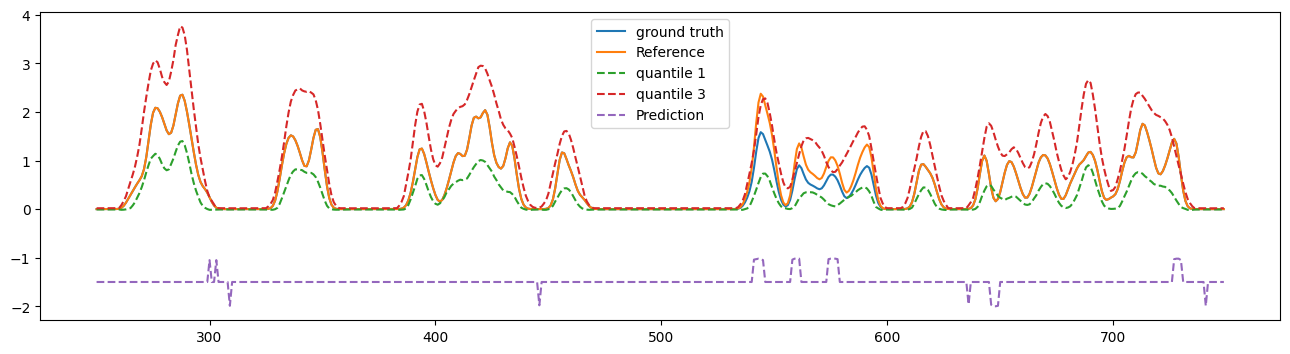

[(364, 0.2542780935764313), (8, 0.24761486053466797), (76, 0.23056308925151825), (248, 0.2132571041584015), (427, 0.20698469877243042)] 905 364


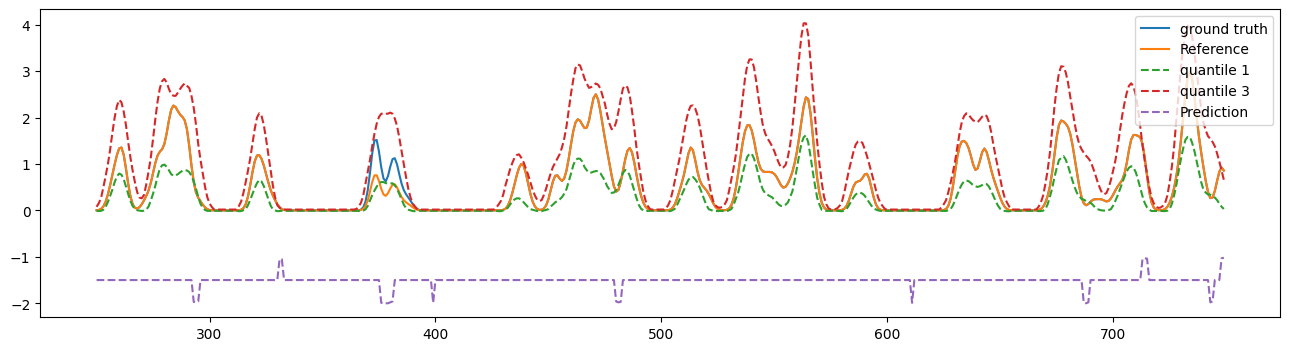

[(726, 0.6961395740509033), (994, 0.3465385138988495), (112, 0.3324313461780548), (245, 0.2714141309261322), (362, 0.2438894510269165)] 726 112


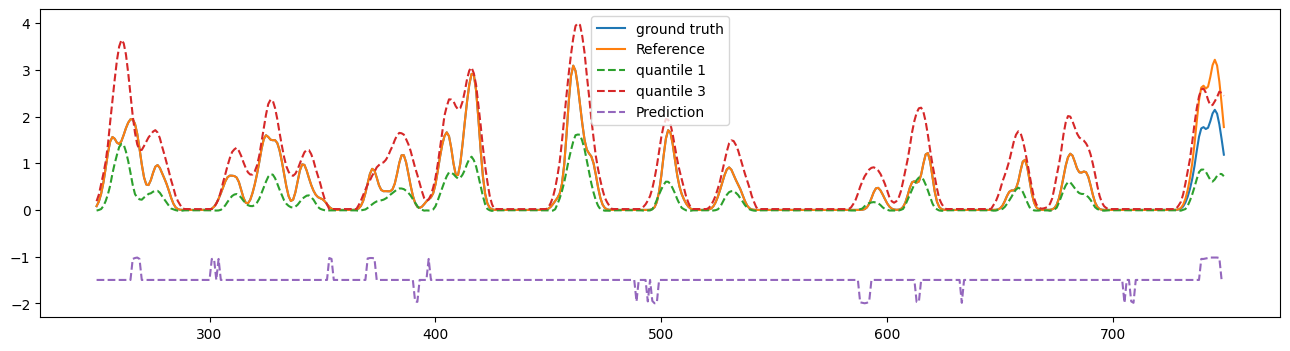

[(63, 0.7002964615821838), (394, 0.2392658293247223), (234, 0.22144535183906555), (691, 0.21776366233825684), (637, 0.17883659899234772)] 146 63


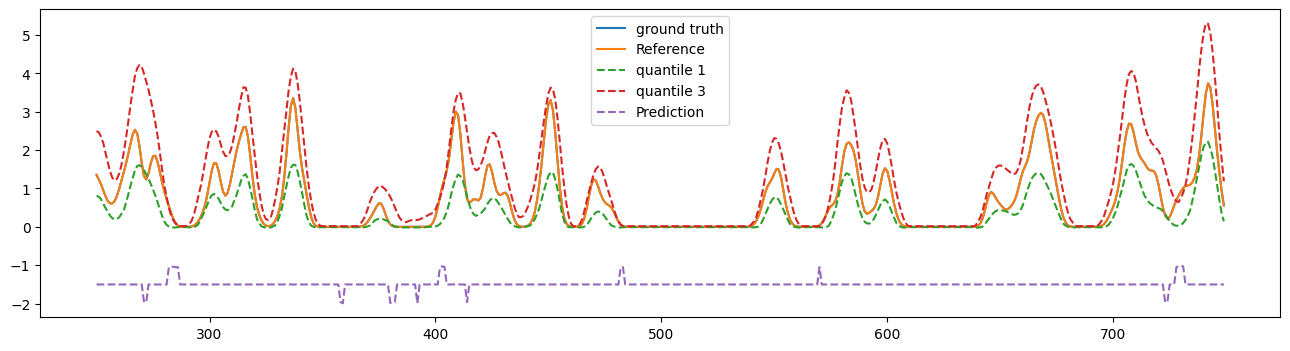

[(434, 0.4378550350666046), (0, 0.2892462909221649), (114, 0.23443956673145294), (530, 0.23055841028690338), (644, 0.19846493005752563)] 434 530


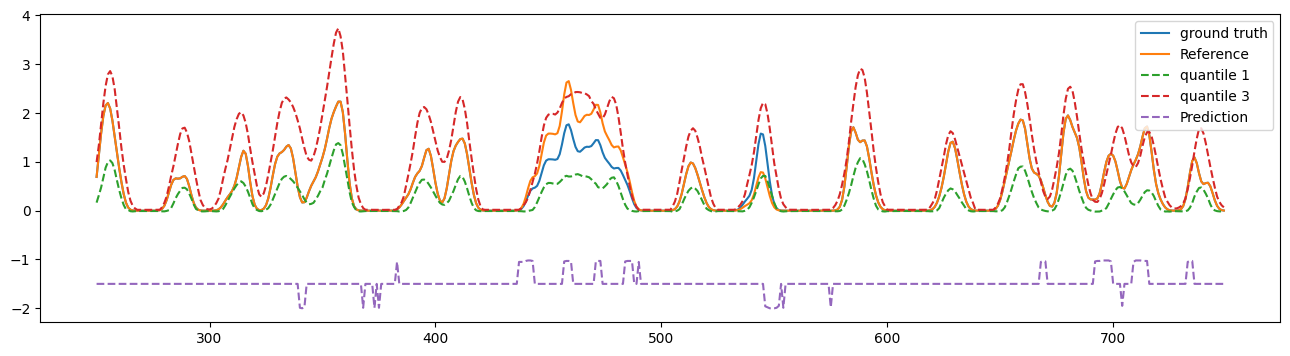

[(443, 0.40341925621032715), (805, 0.20368987321853638), (606, 0.19202920794487), (356, 0.18998105823993683), (315, 0.18416310846805573)] 97 443


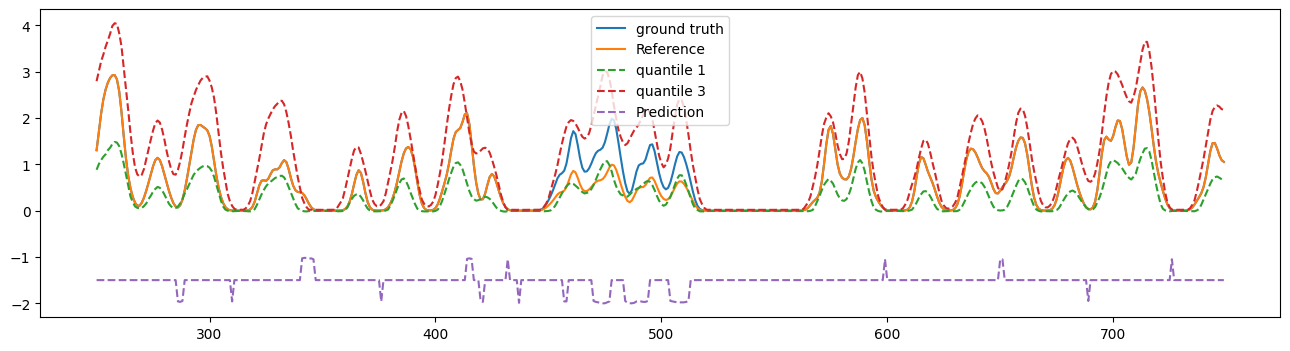

[(363, 0.3194809556007385), (303, 0.3011995851993561), (934, 0.25115305185317993), (184, 0.21603164076805115), (574, 0.18861597776412964)] 975 363


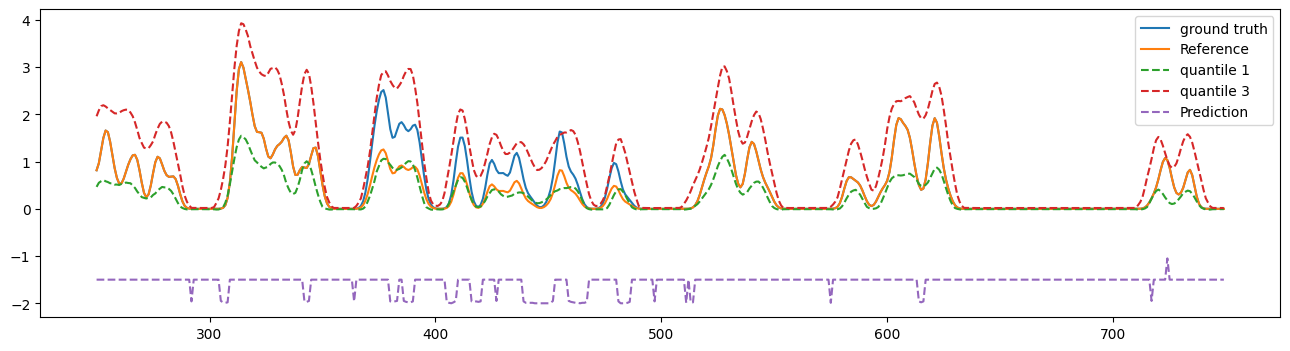

[(587, 0.43610915541648865), (6, 0.35538944602012634), (349, 0.21835806965827942), (319, 0.2028988152742386), (825, 0.16885824501514435)] 319 587


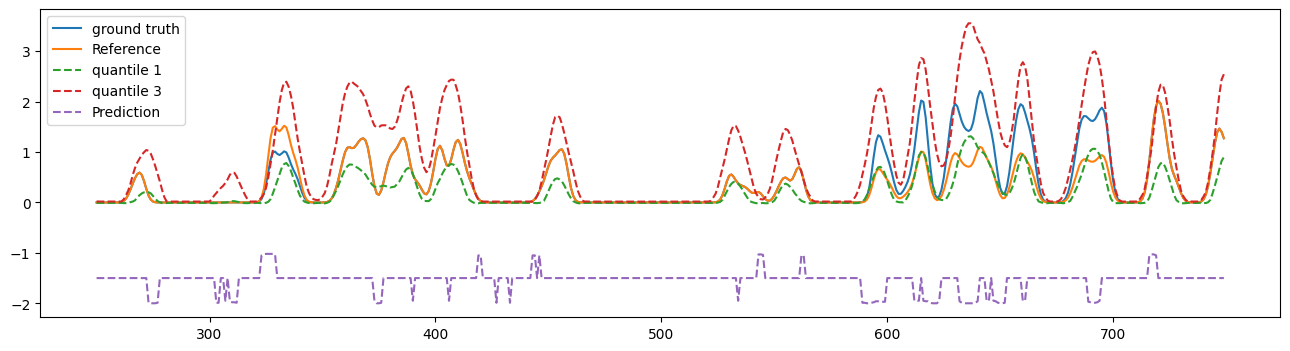

[(140, 0.34587788581848145), (0, 0.23207363486289978), (754, 0.23196649551391602), (557, 0.21564221382141113), (409, 0.21560880541801453)] 637 409


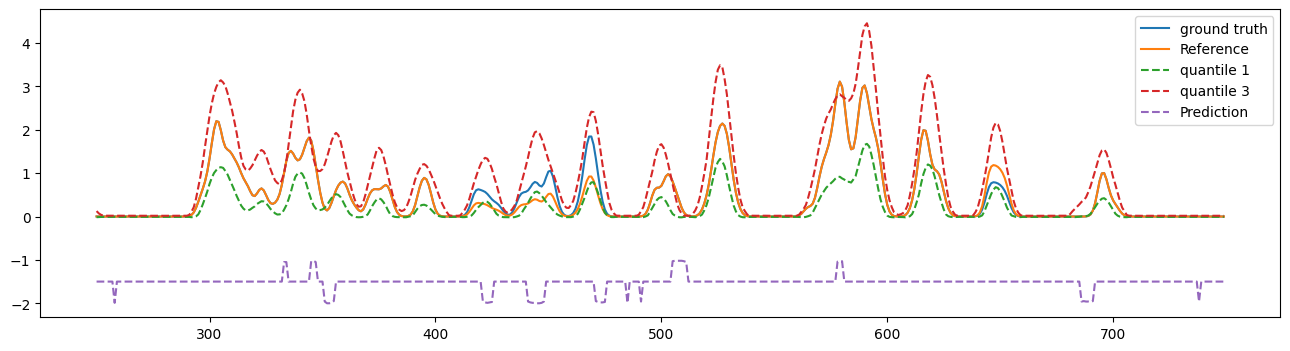

[(155, 0.334825724363327), (969, 0.2991187572479248), (33, 0.27947553992271423), (292, 0.2661936283111572), (72, 0.20767496526241302)] 155 33


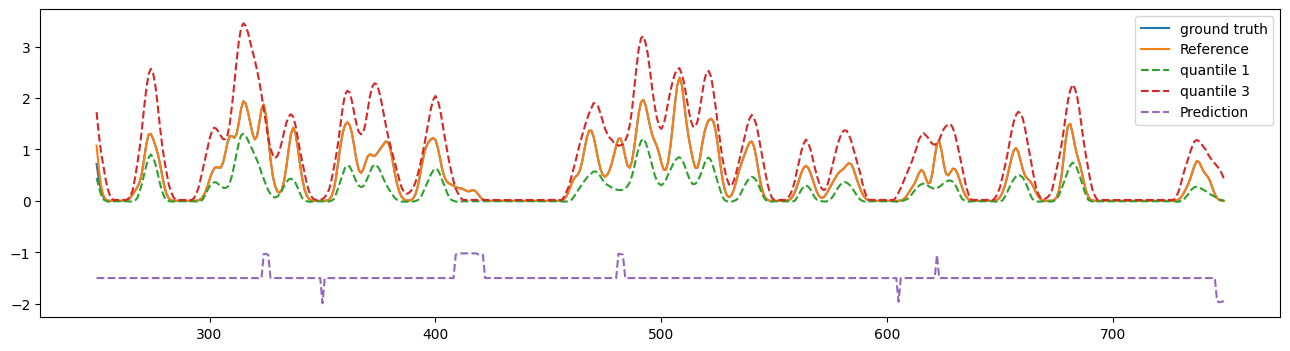

[(984, 0.3002643883228302), (501, 0.23871318995952606), (402, 0.21102887392044067), (752, 0.1894097924232483), (224, 0.17617502808570862)] 752 402


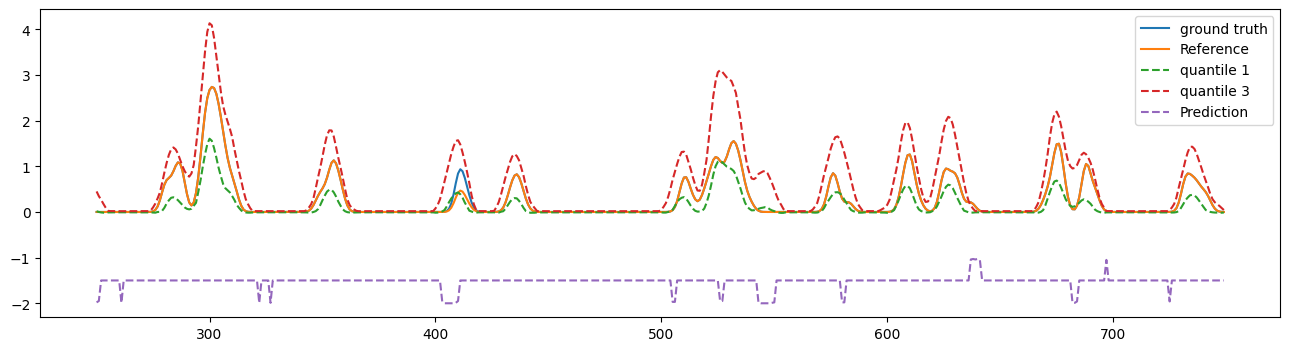

[(374, 0.4684887230396271), (0, 0.3150283992290497), (739, 0.20416897535324097), (537, 0.16053444147109985), (175, 0.1536540985107422)] 374 135


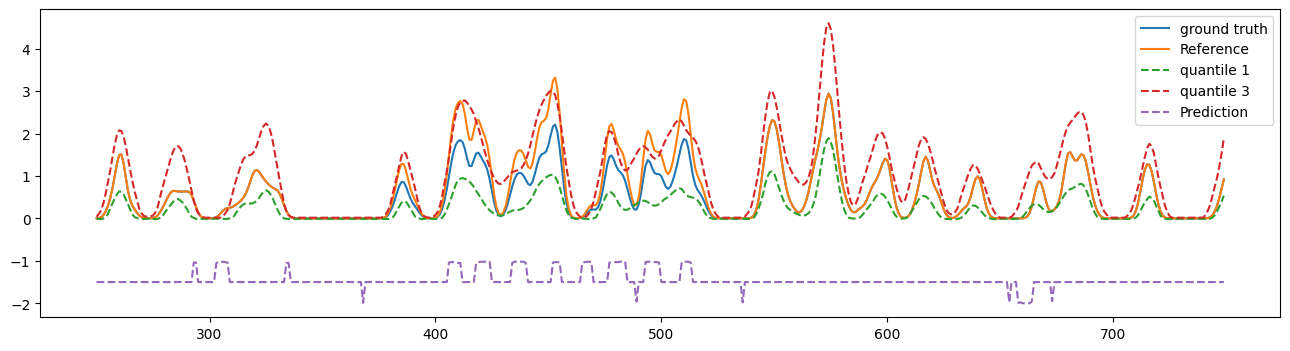

[(67, 0.4938278794288635), (9, 0.3018619120121002), (327, 0.28584086894989014), (262, 0.2607150673866272), (145, 0.2324499636888504)] 9 67


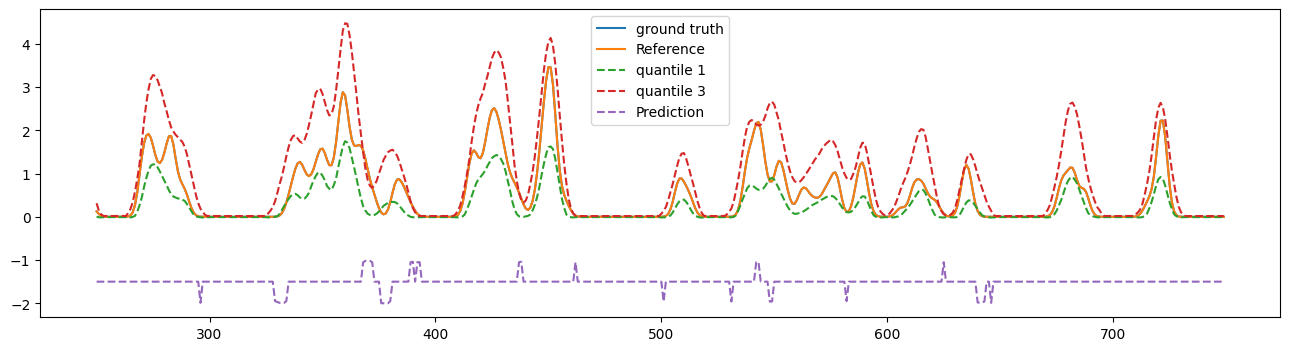

[(798, 0.598706066608429), (562, 0.40403279662132263), (713, 0.34759706258773804), (69, 0.25220930576324463), (0, 0.25129982829093933)] 798 562


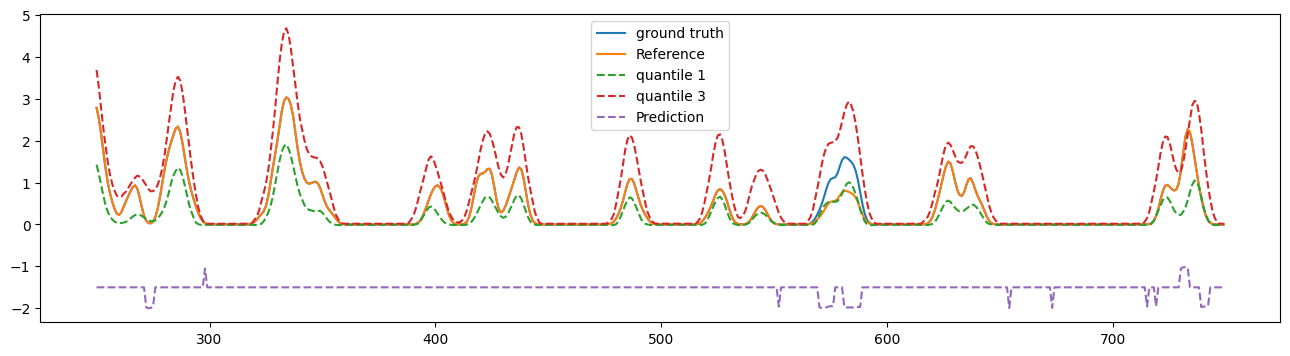

[(882, 0.3829711973667145), (723, 0.32773804664611816), (779, 0.24690158665180206), (630, 0.22434104979038239), (247, 0.22399264574050903)] 583 882


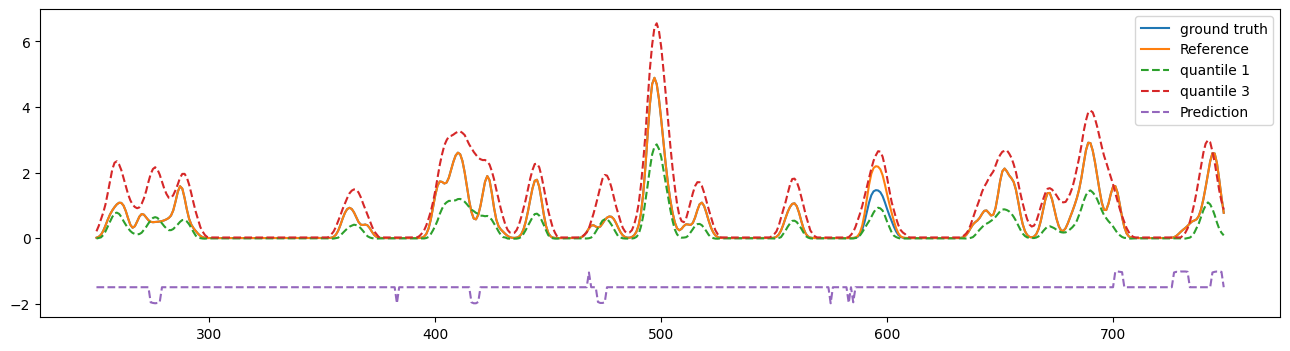

[(489, 0.5259901285171509), (26, 0.39768198132514954), (590, 0.297250360250473), (363, 0.2647814452648163), (97, 0.2445688545703888)] 26 489


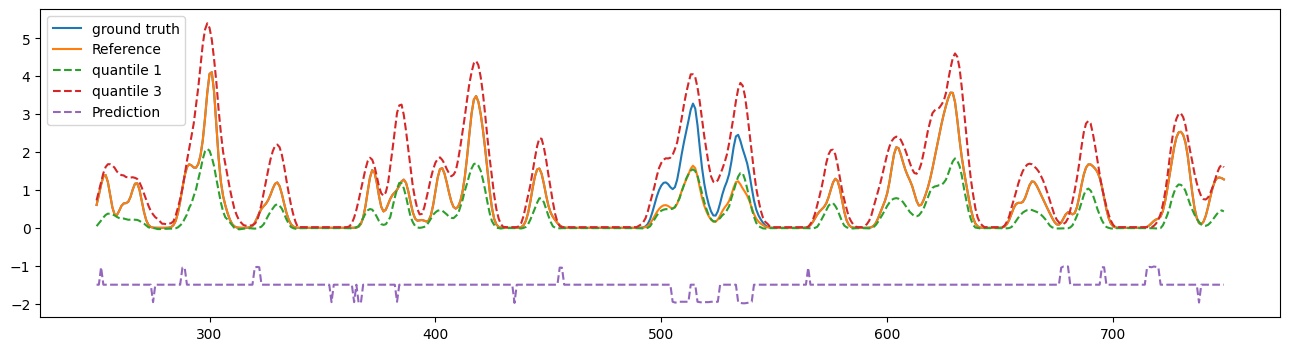

[(905, 0.4541199505329132), (744, 0.3203106224536896), (0, 0.30160894989967346), (315, 0.30137479305267334), (878, 0.23263998329639435)] 878 905


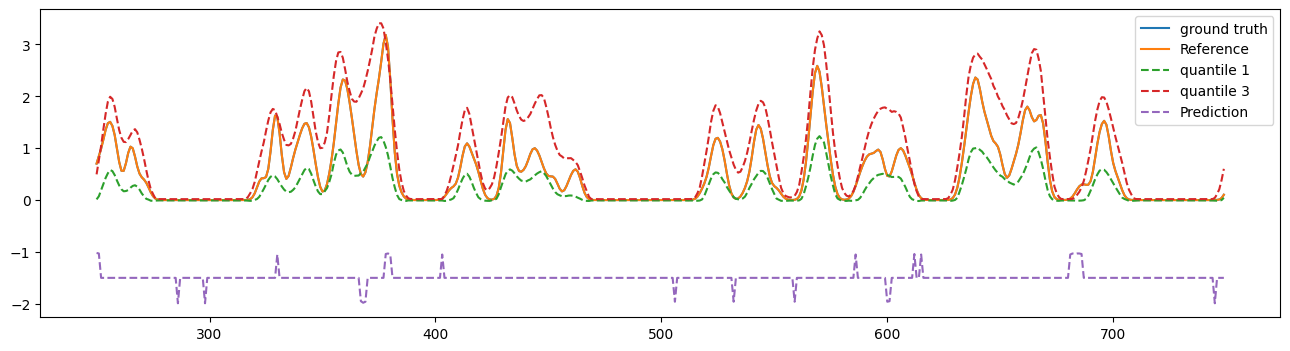

[(332, 0.3678816556930542), (790, 0.25608745217323303), (178, 0.19047142565250397), (746, 0.186381995677948), (633, 0.17984993755817413)] 41 746


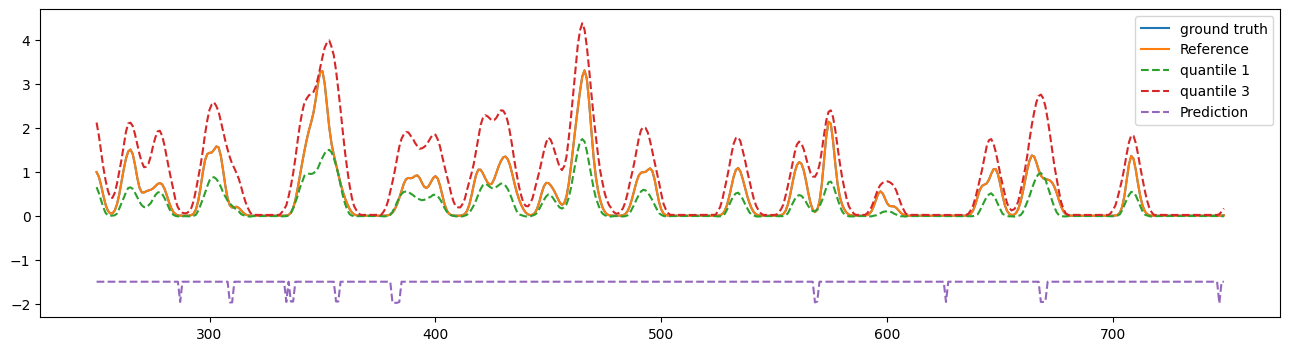

[(901, 0.5236241817474365), (670, 0.25405141711235046), (301, 0.23430462181568146), (460, 0.22902175784111023), (0, 0.18806663155555725)] 901 301


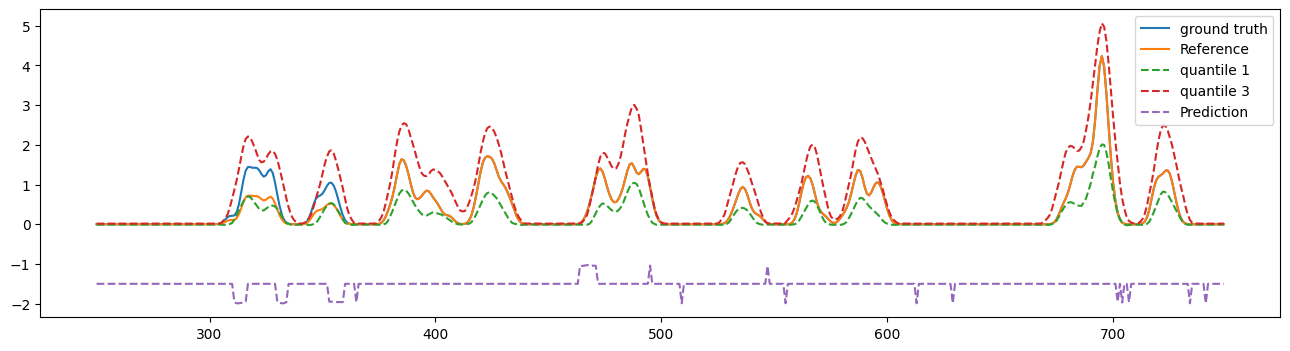

[(13, 0.39714592695236206), (971, 0.2693132758140564), (527, 0.23799404501914978), (802, 0.18863025307655334), (153, 0.16800017654895782)] 13 946


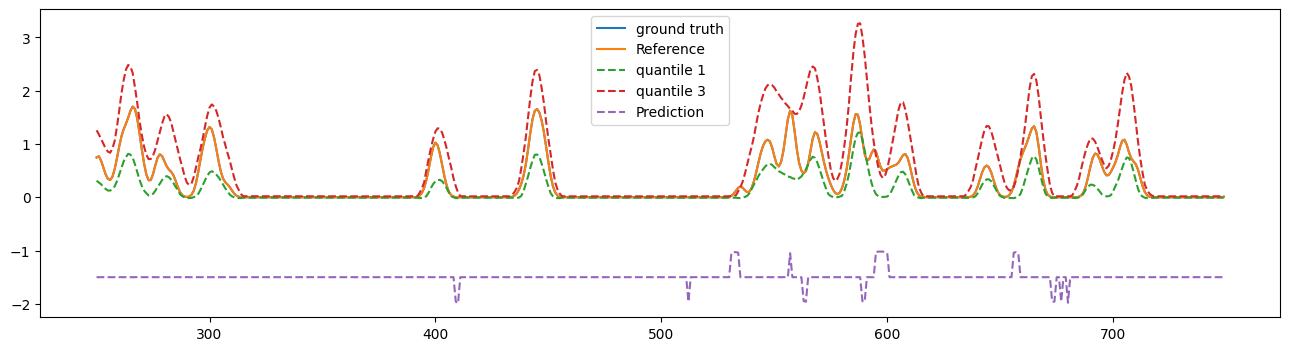

[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
0.55


In [ ]:
def mean_error_per_non_zero_interval(ground_truth, reference, prediction):
    """
    For each non-zero interval in the ground truth, compute the mean quantile order.

    Parameters:
    - ground_truth: A 1D PyTorch tensor representing the ground truth signal.
    - quantile_order: A 1D PyTorch tensor representing the order of the predicted quantile for each time step.

    Returns:
    - A list of tuples, each containing the start of the interval and the mean quantile order, sorted by the mean quantile order.
    """
    # Identify non-zero intervals
    nonzero_positions = ground_truth.nonzero(as_tuple=True)[0]
    if len(nonzero_positions) == 0:
        return []  # Return empty list if there are no non-zero intervals

    diffs = torch.diff(nonzero_positions)
    boundaries = torch.where(diffs > 1)[0]
    interval_starts = torch.cat((nonzero_positions[:1], nonzero_positions[boundaries + 1]))
    interval_ends = torch.cat((nonzero_positions[boundaries], nonzero_positions[-1:]))

    # Compute mean quantile order for each interval
    intervals_info = []
    for start, end in zip(interval_starts, interval_ends):
        MAE = torch.mean(torch.abs((prediction[start:end + 1] - reference[start:end + 1]))).item()
        intervals_info.append((start.item(), MAE))

    # Sort the list by the mean quantile order
    sorted_intervals_info = sorted(intervals_info, key=lambda x: x[1], reverse=True)

    return sorted_intervals_info

def visualize_aggregated_target_quantile(model, data_loader, num_samples=1):
    model.eval()
    k1 = 250
    k2 = 750
    qo = 0.05
    anomaly_prediction = []
    with torch.no_grad():
        for batch_idx, (ground_truth, start, start2, reference, noisy_series) in enumerate(dataloader):

            inputs = noisy_series.to(device).unsqueeze(1).float()  # Adjust input dimensions
            outputs = model(inputs).cpu()
            for i in range(num_samples):
                plt.figure(figsize=(16, 4))
                # plt.plot(noisy_series[i].squeeze(), label='input')
                plt.plot(range(k1,k2), ground_truth[i].squeeze()[k1:k2], label='ground truth')
                plt.plot(range(k1,k2), reference[i].squeeze()[k1:k2], label='Reference')
                plt.plot(range(k1,k2), outputs[i,int(100*qo)][k1:k2], label='quantile 1', linestyle='--')
                plt.plot(range(k1,k2), outputs[i,int(100*(1-qo))][k1:k2], label='quantile 3', linestyle='--')
                nearest_quantile = find_nearest_quantile_indices(outputs[i], reference[i].squeeze()) / 100.
                mq = mean_error_per_non_zero_interval(ground_truth[i].squeeze(), reference[i].squeeze(), outputs[i,49])
                nearest_quantile[(nearest_quantile < 1-qo) * (nearest_quantile > qo)] = 0.5
                starti = int(start[i].item())
                start2i = int(start2[i].item())

                print(mq[:5], starti, start2i)
                starts_mq = [t[0] for t in  mq[:2]]
                anomaly_prediction.append( 0.5 * ( (start2i in starts_mq) + (start2i in starts_mq) ) )

                plt.plot(range(k1,k2), nearest_quantile[k1:k2] -2, label='Prediction', linestyle='--')
                plt.legend()
                plt.show()
            break  # Just show the first batch

    return anomaly_prediction


anomaly_prediction = visualize_aggregated_target_quantile(model, dataloader, num_samples=20)

print(anomaly_prediction)
print(np.mean(anomaly_prediction))